# Initialization

Here we install the necessary packages and load the absolute and relative imports. Notice that pandas-profiling is commented-out, we only used it for Milestone 1 to obtain the HTML summaries (see zip folder and pandas-profiling section at the end of the notebook).

In [0]:
# Installs
!pip install jax
!pip install -q kaggle
!pip install numpyro
#!pip install pandas-profiling
!pip install pyro-ppl

In [0]:
# Upload kaggle key -> kaggle.json (from zip folder)
from google.colab import files
files.upload();

In [0]:
# Imports and set-up
import datetime as dt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro # ; numpyro.set_host_device_count(2) to change num_chains (doesn't work!)
import numpyro.distributions as npdist
import os
import pandas as pd
import seaborn as sns
import sklearn
import time
import torch
import pyro
import pyro.distributions as dist

from IPython.core.display import display, HTML
from jax import jit, lax, random, vmap
from jax.scipy.special import logsumexp
from numpyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from numpyro.infer import MCMC, NUTS, HMC, SVI, ELBO, RenyiELBO
from numpyro.infer.util import init_to_prior, init_to_uniform, init_to_feasible, init_to_median
from numpyro import optim
#from pandas_profiling import ProfileReport
from pyro.contrib.autoguide import AutoMultivariateNormal
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tqdm.notebook import tqdm

In [0]:
# Fix random generator seed (for reproducibility of results)
np.random.seed(123)

# Set random key for numpyro (for reproducibility of results)
rng_key = random.PRNGKey(123)
rng_key, rng_key_ = random.split(rng_key)

# Matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [0]:
# Move kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permissions change to avoid Kaggle tool startup warning
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle API
!kaggle competitions download -c ashrae-energy-prediction

# Functions

## General
Here we define functions we will be using in the notebook, these are general-purpose functions only.

In [0]:
def logger(f):
    """
    Given a function, logger and wrapper work as timestamps, computes the time it takes
    for the function to finish. Returns the elapsed time.
    """

    def wrapper(df, *args, **kwargs):
        tic = dt.datetime.now()
        result = f(df, *args, **kwargs)
        toc = dt.datetime.now()
        print(f"{f.__name__} took {tic-tic} secs, shape{result.shape}")
        return result

    return wrapper

def start_pipeline(df):
    """Starts a pipeline when working on a dataframe, returns a copied df.""" 

    return df.copy()

def reduce_mem_usage(df, verbose=True):
    """
    Reduces memory usage of the dataframe by converting the data types to light-weight 
    data types. Returns the same df with the converted data types per column.

    See https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction
    """

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
        end_mem, 100 * (start_mem - end_mem) / start_mem)
    )
    return df

def select_meter(df, meter=0): # Electricity = 0
    """Drops the observations that are not selected."""

    return df[df.meter==0].drop(columns=['meter'])

def drop_outliers(df, threshold=5000):
    """Keeps the observations that are below certain threshold."""

    return df[df.meter_reading<threshold].copy()

def to_datetime(df):
    """Converts the 'timestamp' column of a df to DateTime type."""

    df.timestamp = pd.to_datetime(df.timestamp)
    return df

def compute_error(trues, predicted):
    """
    Computes the error given a vector of actual measurements against predicted. Returns
    a list with the correlation, MAE, RAE, RMSE, and R2 between these two vectors.
    """

    corr = np.corrcoef(predicted, trues)[0, 1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return [corr, mae, rae, rmse, r2]

def compute_predictions(samples, y_std, y_mean):
    """
    Computes the mean and standard deviation of a given sample and re-normalizes the
    values given a certain mean and standard deviation. Returns a re-normalized vector.
    """

    y_hat_mean = samples.mean(axis=0).reshape(-1,)
    y_hat_std = samples.std(axis=0).reshape(-1,)
    # y_hat_025 = (y_hat_mean - 1.96*y_hat_std) * y_std + y_mean
    # y_hat_975 = (y_hat_mean + 1.96*y_hat_std) * y_std + y_mean
    y_hat_renormalized = y_hat_mean * y_std + y_mean
    return y_hat_renormalized #, y_hat_025, y_hat_975

## Models
Here we define all the models we will be using during the forecasts.


1.   Bayesian Linear Regression
2.   Hierarchiacal Linear Regression
3.   Linear Dynamical System with autoregressive lag 1, 2, 24, 168 (plus lax.scan functions)
4.   Linear Dynamical System with autoregressive lag 1, 2, 24, 168 with inputs (plus lax.scan functions)



In [0]:
# Bayesian Linear Regression
def model_blr(X, obs=None):
    """
    Given an input matrix X, defines a bayesian linear regression model with priors for
    alpha, beta, sigma and a plate with the target variable. Returns the target variable.
    """
    
    alpha = pyro.sample("alpha", dist.Normal(0., 5.)) # Prior for the bias/intercept
    beta  = pyro.sample("beta", 
                        dist.Normal(torch.zeros(X.shape[1]),
                                    5.*torch.ones(X.shape[1]))) # Priors for the reg coefs
    sigma = pyro.sample("sigma", dist.HalfCauchy(5)) # Prior for the variance
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

# Hierarchical Model
def model_hm(X, ind, n_households, site, n_sites, obs=None):
    """
    Given an input matrix X, defines a hierarchical model with hyperpriors for sigma of
    each building and normal priors for beta and sigma. Returns the target variable.
    """

    N, M = X.shape
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 5.))
    alpha_sigma = pyro.sample("alpha_sigma", dist.HalfCauchy(5.))
    # beta_mu = pyro.sample("beta_mu", dist.Normal(torch.zeros(M), 5.*torch.ones(M)))
    # beta_sigma = pyro.sample("beta_sigma", dist.HalfCauchy(5.*torch.ones(M)))
    beta = pyro.sample("beta", dist.Normal(torch.zeros(M), 5.*torch.ones(M)))
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.)) # Prior for the variance

    # If we want different betas for each household
    # with pyro.plate("households", n_households):
    #     beta = pyro.sample("beta", dist.Normal(beta_mu, beta_sigma).to_event(1))
    
    # If we want different alphas for each site
    with pyro.plate("sites", n_sites):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event(0))
        # sigma = pyro.sample("sigma", dist.HalfCauchy(5.).to_event(0)) # Prior for the var
    with pyro.plate("data", N):
        y = pyro.sample("y", dist.Normal(alpha[site] + X.matmul(beta.T), sigma), obs=obs)
        
    return y

# LDS AR1
def f_AR1(carry, noise_t):
    """Used in lax.scan, computes z_t and adjusts z_prev1."""

    beta1, z_prev1, tau = carry
    z_t = beta1*z_prev1 + tau*noise_t
    z_prev1 = z_t
    return (beta1, z_prev1, tau), z_t


def model_AR1(T, T_forecast, obs=None):
    """
    Define priors over beta1, tau, noises, sigma, and z_prev1. Uses jax.lax.scan and f_AR1.
    Returns the collection of latent variables z_collection for the observed and forecasted
    observations.
    """

    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-1),
                                                    jnp.ones(T+T_forecast-1)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    z_prev1 = numpyro.sample("z_prev1", npdist.Normal(0, 3.))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, z_prev1, tau)
    z_collection = [z_prev1]
    carry, zs_exp = lax.scan(f=f_AR1, init=carry, xs=noises, length=T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed_y (y_obs) and predicted_y (y_hat)
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

# LDS AR2
def f_AR2(carry, noise_t):
    """Used in lax.scan, computes z_t and adjusts z_prev1 and z_prev2."""

    beta1, beta2, z_prev1, z_prev2, tau = carry
    z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, z_prev1, z_prev2, tau), z_t

def model_AR2(T, T_forecast, obs=None):
    """
    Define priors over beta1, beta2, tau, noises, sigma, and z_prev1 and z_prev2. Uses 
    jax.lax.scan and f_AR2. Returns the collection of latent variables z_collection for the 
    observed and forecasted observations.
    """

    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-2),
                                                    jnp.ones(T+T_forecast-2)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta2 = numpyro.sample("beta2", npdist.Normal(0, 5.))
    z_prev1 = numpyro.sample("z_prev1", npdist.Normal(0, 3.))
    z_prev2 = numpyro.sample("z_prev2", npdist.Normal(0, 3.))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f=f_AR2, init=carry, xs=noises, length=T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed_y (y_obs) and predicted_y (y_hat)
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

# LDS AR24
def f_AR24(carry, noise_t):
    """Used in lax.scan, computes z_t and adjusts zetas array."""

    beta1, beta24, zetas, tau = carry
    z_t = beta1*zetas['z1'] + beta24*zetas['z24'] + tau*noise_t
    for x in range(24,0,-1):
        if x==1:
            zetas["z{0}".format(x)] = z_t
        else:
            zetas["z{0}".format(x)] = zetas["z{0}".format(x-1)]
    return (beta1, beta24, zetas, tau), z_t

def model_AR24(T, T_forecast, obs=None):
    """
    Define priors over beta1, beta24, tau, noises, sigma, and zetas (1 to 24). Uses 
    jax.lax.scan and f_AR24. Returns the collection of latent variables z_collection for the 
    observed and forecasted observations.
    """

    z_dict = {}
    for x in range(1,25):
        z_dict["z{0}".format(x)] = numpyro.sample("z_prev"+str(x), npdist.Normal(0, 5.))
    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-24),
                                                    jnp.ones(T+T_forecast-24)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta24 = numpyro.sample("beta24", npdist.Normal(0, 5.))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta24, z_dict, tau)
    z_collection = [z_dict["z{0}".format(x)] for x in range(1, 25)]
    carry, zs_exp = lax.scan(f=f_AR24, init=carry, xs=noises, length=T+T_forecast-24)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed_y (y_obs) and predicted_y (y_hat)
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

# LDS AR168
def f_AR168(carry, noise_t):
    """Used in lax.scan, computes z_t and adjusts zetas array."""

    beta1, beta24, beta168, zetas, tau = carry
    z_t = beta1*zetas['z1'] + beta24*zetas['z24'] + beta168*zetas['z168'] + tau*noise_t
    for x in range(168,0,-1):
        if x==1:
            zetas["z{0}".format(x)] = z_t
        else:
            zetas["z{0}".format(x)] = zetas["z{0}".format(x-1)]
    return (beta1, beta24, beta168, zetas, tau), z_t

def model_AR168(T, T_forecast, obs=None):
    """
    Define priors over beta1, beta24, beta168, tau, noises, sigma, and zetas (1 to 168). 
    Uses jax.lax.scan and f_AR168. Returns the collection of latent variables z_collection 
    for the observed and forecasted observations.
    """

    z_dict = {}
    for x in range(1,169):
        z_dict["z{0}".format(x)] = numpyro.sample("z_prev"+str(x), npdist.Normal(0, 5.))
    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-168),
                                                    jnp.ones(T+T_forecast-168)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta24 = numpyro.sample("beta24", npdist.Normal(0, 5.))
    beta168 = numpyro.sample("beta168", npdist.Normal(0, 5.))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta24, beta168, z_dict, tau)
    z_collection = [z_dict["z{0}".format(x)] for x in range(1, 169)]
    carry, zs_exp = lax.scan(f=f_AR168, init=carry, xs=noises, length=T+T_forecast-168)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed_y (y_obs) and predicted_y (y_hat)
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

# LDS AR1 with inputs
def f_AR1x(carry, inputs):
    """Used in lax.scan, computes z_t with inputs and adjusts z_prev1."""

    x_prev, noise_t = inputs
    beta1, z_prev1, eta, tau = carry
    z_t = beta1 * z_prev1 + jnp.dot(x_prev, eta) + tau * noise_t
    z_prev1 = z_t
    return (beta1, z_prev1, eta, tau), z_t

def model_AR1x(T, T_forecast, X, obs=None):
    """
    Define priors over beta1, tau, eta, noises, sigma, and z_prev1. Uses jax.lax.scan and
    f_AR1x. Returns the collection of latent variables z_collection for the observed and
    forecasted observations.
    """

    N, M = X.shape
    tau = numpyro.sample("tau", npdist.HalfCauchy(1.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-1),
                                                    jnp.ones(T+T_forecast-1)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(5.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    z_prev1 = numpyro.sample("z_prev1", npdist.Normal(0, 5.))
    eta = numpyro.sample("eta", npdist.Normal(jnp.zeros(M), 5.0 * jnp.ones(M)))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, z_prev1, eta, tau)
    z_collection = [z_prev1]
    carry, zs_exp = lax.scan(f=f_AR1x,
                             init=carry,
                             xs=(X, noises),
                             length=T+T_forecast-1
                             )
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed_y (y_obs) and predicted_y (y_hat)
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

# LDS AR2 with inputs
def f_AR2x(carry, inputs):
    """Used in lax.scan, computes z_t with inputs and adjusts z_prev1 and z_prev2."""

    x_prev, noise_t = inputs
    beta1, beta2, z_prev1, z_prev2, eta, tau = carry
    z_t = beta1 * z_prev1 + beta2 * z_prev2 + jnp.dot(x_prev, eta) + tau * noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, z_prev1, z_prev2, eta, tau), z_t

def model_AR2x(T, T_forecast, X, obs=None):
    """
    Define priors over beta1, beta2, tau, eta, noises, sigma, and z_prev1 and z_prev2. 
    Uses jax.lax.scan and f_AR2x. Returns the collection of latent variables z_collection 
    for the observed and forecasted observations.
    """

    N, M = X.shape
    tau = numpyro.sample("tau", npdist.HalfCauchy(1.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-2),
                                                    jnp.ones(T+T_forecast-2)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(5.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta2 = numpyro.sample("beta2", npdist.Normal(0, 5.))
    z_prev1 = numpyro.sample("z_prev1", npdist.Normal(0, 5.))
    z_prev2 = numpyro.sample("z_prev2", npdist.Normal(0, 5.))
    eta = numpyro.sample("eta", npdist.Normal(jnp.zeros(M), 5.0 * jnp.ones(M)))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, z_prev1, z_prev2, eta, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f=f_AR2x,
                             init=carry,
                             xs=(X, noises),
                             length=T+T_forecast-2
                             )
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed_y (y_obs) and predicted_y (y_hat)
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

# LDS AR24 with inputs
def f_AR24x(carry, inputs):
    """Used in lax.scan, computes z_t with inputs and adjusts zetas array."""

    x_prev, noise_t = inputs
    beta1, beta24, zetas, eta, tau = carry
    z_t = beta1 * zetas['z1'] + beta24*zetas['z24'] + jnp.dot(x_prev, eta) + tau * noise_t
    for x in range(24,0,-1):
        if x==1:
            zetas["z{0}".format(x)] = z_t
        else:
            zetas["z{0}".format(x)] = zetas["z{0}".format(x-1)]
    return (beta1, beta24, zetas, eta, tau), z_t

def model_AR24x(T, T_forecast, X, obs=None):
    """
    Define priors over beta1, beta24, tau, eta, noises, sigma, and zetas (1 to 24). Uses 
    jax.lax.scan and f_AR24x. Returns the collection of latent variables z_collection for 
    the observed and forecasted observations.
    """

    N, M = X.shape
    z_dict = {}
    for x in range(1,25):
        z_dict["z{0}".format(x)] = numpyro.sample("z_prev"+str(x), npdist.Normal(0, 5.))
    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-24),
                                                    jnp.ones(T+T_forecast-24)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta24 = numpyro.sample("beta24", npdist.Normal(0, 5.))
    eta = numpyro.sample("eta", npdist.Normal(jnp.zeros(M), 5.0 * jnp.ones(M)))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta24, z_dict, eta, tau)
    z_collection = [z_dict["z{0}".format(x)] for x in range(1, 25)]
    carry, zs_exp = lax.scan(f=f_AR24x, init=carry, xs=(X, noises), length=T+T_forecast-24)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed_y (y_obs) and predicted_y (y_hat)
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

# LDS AR168 with inputs
def f_AR168x(carry, inputs):
    """Used in lax.scan, computes z_t with inputs and adjusts zetas array."""

    x_prev, noise_t = inputs
    beta1, beta24, beta168, zetas, eta, tau = carry
    z_t = beta1 * zetas['z1'] + beta24*zetas['z24'] + beta24*zetas['z168'] + jnp.dot(x_prev, eta) + tau * noise_t
    for x in range(168,0,-1):
        if x==1:
            zetas["z{0}".format(x)] = z_t
        else:
            zetas["z{0}".format(x)] = zetas["z{0}".format(x-1)]
    return (beta1, beta24, beta168, zetas, eta, tau), z_t

def model_AR168x(T, T_forecast, X, obs=None):
    """
    Define priors over beta1, beta24, beta168, tau, eta, noises, sigma, and zetas (1 to 168)
    Uses jax.lax.scan and f_AR168x. Returns the collection of latent variables z_collection
    for the observed and forecasted observations.
    """

    N, M = X.shape
    z_dict = {}
    for x in range(1,169):
        z_dict["z{0}".format(x)] = numpyro.sample("z_prev"+str(x), npdist.Normal(0, 5.))
    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-168),
                                                    jnp.ones(T+T_forecast-168)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta24 = numpyro.sample("beta24", npdist.Normal(0, 5.))
    beta168 = numpyro.sample("beta168", npdist.Normal(0, 5.))
    eta = numpyro.sample("eta", npdist.Normal(jnp.zeros(M), 5.0 * jnp.ones(M)))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta24, beta168, z_dict, eta, tau)
    z_collection = [z_dict["z{0}".format(x)] for x in range(1, 169)]
    carry, zs_exp = lax.scan(f=f_AR168x, init=carry, xs=(X, noises), length=T+T_forecast-168)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed_y (y_obs) and predicted_y (y_hat)
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

# Data
Here we load the data from the csv files and conduct a high level cleaning of the data, including: drop unused data, filtering, and unit conversion. The dataset "Great Energy Predictor III" includes one year of hourly measurements from 1448 buildings of different types. This assignment will focus on households, therefore only 145 houses will be used. The raw variables are:

- building\_id (categorical) - Foreign key for the building metadata.
- meter (numerical) - The meter id code. \{0: electricity, 1: chilledwater, 2: steam, 3: hotwater\}.
- timestamp (date) - When the measurement was taken
- meter\_reading} (numerical) - The target variable - electricity consumption in kWh
- site\_id (categorical) - Foreign key for the weather station
- primary\_use (categorical) - Indicator of the primary category of activities
- square\_feet (numerical) - Gross floor area of the building
- year\_built (categorical) - Year when the building was opened
- floor\_count (numerical) - Number of floors of the building
- air\_temperature (numerical) - Air temperature in degrees Celsius
- cloud\_coverage (numerical) - Portion of the sky covered in clouds, in oktas
- dew\_temperature (numerical) - Dew temperature in degrees Celsius
- precip\_depth\_1\_hr (numerical) - Millimeters of precipitation depth per hour
- sea\_level\_pressure (numerical) - Pressure in millibar/hectopascals
- wind\_direction (numerical) - Compass direction (0-360°)
- wind\_speed (numerical) - Wind speed in meters per second

In [8]:
# Load data into DataFrames
df_meta_raw = pd.read_csv('building_metadata.csv')
df_raw = pd.read_csv('train.csv.zip')
df_weather_raw = pd.read_csv('weather_train.csv.zip')

# Run pipeline to reduce memory changing data types of each column
df = (df_raw.pipe(start_pipeline)
            .pipe(reduce_mem_usage)
            .pipe(select_meter) # only electricity
            #.pipe(drop_outliers) # check this threshold, we haven't done any visual check
            .pipe(to_datetime))
df_meta = (df_meta_raw.pipe(start_pipeline)
                      .pipe(reduce_mem_usage))
df_weather = (df_weather_raw.pipe(start_pipeline)
                            .pipe(reduce_mem_usage)
                            .pipe(to_datetime))

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)


In [0]:
# Filter raw datasets to include only households
df_meta = df_meta[df_meta.primary_use.eq('Lodging/residential')]
hh_id = df_meta.building_id.unique()
df = df[df.building_id.isin(hh_id)]
hh_id2 = df.building_id.unique() # repeat because 2 ids are missing from df_meta
df_meta = df_meta[df_meta.building_id.isin(hh_id2)]
hh_site_id = df_meta.site_id.unique()
df_weather = df_weather[df_weather.site_id.isin(hh_site_id)]

After an initial inspection of the filtered dataset (see Data Visualization section), it was decided to remove the following variables:

- primary\_use - the dataset is already filtered for 'Lodging/residential'
- floor\_count - missing values for residential at 87.6\% and the variable square\_feet already represents the space
- cloud\_coverage - missing for residential at 47.6\% and it isn't representative to the model's story
- wind\_direction - there's no data about the geometry and position of the building, so it doesn't fit into the model's story
- precip\_depth\_1\_hr - missing for residential at 24.5\% without information to impute or ignore
- year\_built - missing data around 40%, we had to sadly remove this variable but we think it'd be really interesting when having a complete dataset to use it. In theory, if the building is newer the materials and technology used to construct it should make it more efficient, therefore reducing the consumption.

In [0]:
# Join datasets and set timestamp as index
df = df.set_index('building_id').join(df_meta.set_index('building_id'), how='inner')
df = df.reset_index() # to keep building_id
df = df.set_index('timestamp').merge(df_weather.set_index('timestamp'),
                                    on=['site_id', 'timestamp'],
                                    how='left')

# Drop unused variables
df = df.drop(columns=['primary_use',
                      'floor_count',
                      'cloud_coverage',
                      'precip_depth_1_hr',
                      'wind_direction',
                      'year_built',
                      ])

df = df[df.building_id != 671].copy() # drop building with no sea_level_pressure

A clan index is created to compare with each building's measurements, also an array of the building_id of the buildings with complete measurements (24 hrs * 366 days = 8784) are kept to filter the dataset later. 

In [0]:
# Get array of building ids with all measurements and clean datetime idx
df_counts = df.groupby('building_id').count()
complete_ids = df_counts[df_counts.meter_reading == 8784].index
clean_idx = pd.date_range(pd.to_datetime('2016-01-01'),
                          pd.to_datetime('2017-01-01'),
                          freq='H',
                          closed='left')

Buildings at site 0 had to be converted to kWh (as the other buildings in other sites), this was an error coming from the dataset

In [0]:
# Change site_id 0 to kWh instead of kBTU
rate = 0.2931 # from kBTU to kWh
df.loc[df['site_id'] == 0, 'meter_reading'] = df[df['site_id'] == 0]['meter_reading'] * rate

There are some nans in the weather variables, these will be later interpolated.

In [13]:
pd.set_option('float_format', '{:.1f}'.format)
df.describe()
# print(df.describe().to_latex(index=False))

building_id  meter_reading  ...  sea_level_pressure  wind_speed
count    1220298.0      1220298.0  ...           1183642.0   1208026.0
mean         705.2           84.8  ...                 nan         nan
std          512.3          113.2  ...                 nan         0.0
min            6.0            0.0  ...               973.5         0.0
25%          134.0           21.4  ...              1012.5         2.1
50%          774.0           52.2  ...              1016.5         3.1
75%         1186.0          104.4  ...              1021.0         4.6
max         1447.0        12571.0  ...              1046.0        18.5

[8 rows x 8 columns]

In [14]:
df.isna().sum()
#(df.isna().sum()/df.shape[0])*100

building_id               0
meter_reading             0
site_id                   0
square_feet               0
air_temperature        9119
dew_temperature        9279
sea_level_pressure    36656
wind_speed            12272
dtype: int64

In [15]:
df.dtypes

building_id             int64
meter_reading         float32
site_id                  int8
square_feet             int32
air_temperature       float16
dew_temperature       float16
sea_level_pressure    float16
wind_speed            float16
dtype: object

The following two dataframes show the top 10 buildings with the most mean and variance, there are some very odd buildings like 927. This building has a very high variance and a larger mean compared to all the other buildings (see Data Visualization section to see the plot of this odd building).

In [16]:
df_mean = df.groupby('building_id').mean()
df_mean.sort_values(by=['meter_reading'], ascending=False)[0:10]

meter_reading  site_id  ...  sea_level_pressure  wind_speed
building_id                          ...                                
927                  841.6        9  ...              1016.5         2.1
166                  393.1        2  ...              1011.5         2.9
1222                 358.4       13  ...              1016.0         4.2
203                  346.2        2  ...              1011.5         2.9
374                  331.6        3  ...              1018.0         3.9
932                  320.4        9  ...              1016.5         2.1
1154                 264.0       13  ...              1016.0         4.2
1365                 261.2       15  ...              1017.0         3.5
1440                 254.0       15  ...              1017.0         3.5
971                  240.8        9  ...              1016.5         2.1

[10 rows x 7 columns]

In [17]:
df_var = df.groupby('building_id').var()
df_var.sort_values(by=['meter_reading'], ascending=False)[0:10]

meter_reading  site_id  ...  sea_level_pressure  wind_speed
building_id                          ...                                
927               170372.9        0  ...                36.8         2.3
374                11182.4        0  ...                48.2         5.2
95                  7884.4        0  ...                16.3         4.6
166                 7056.6        0  ...                24.4         3.9
932                 6994.2        0  ...                36.8         2.3
98                  6878.6        0  ...                16.3         4.6
1154                6399.6        0  ...                58.6         5.4
62                  6247.3        0  ...                16.3         4.6
33                  5963.5        0  ...                16.3         4.6
96                  5463.5        0  ...                16.3         4.6

[10 rows x 7 columns]

# Data Visualization
Here we visualize the data prepared in the last section. 

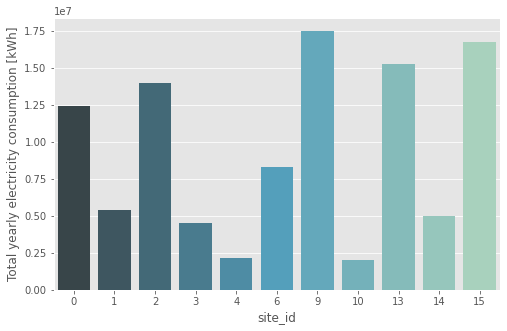

In [18]:
# site_id vs. total energy consumption
plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.groupby('site_id').sum().index, 
            y=df.groupby('site_id').sum().meter_reading,
            palette="GnBu_d")
ax.set(ylabel='Total yearly electricity consumption [kWh]')
fig = ax.get_figure()
# fig.savefig('consumption_site.png')
# files.download("consumption_site.png")

The previous figure shows the total yearly electricty in each site. We can see that site 4 and 10 have the lowest consumption, it could be that these zones don't require much air conditioning or simply because the number of sites is lower. The dataset is unbalanced, meaning that there are sites with more buildings compared to other sites. 

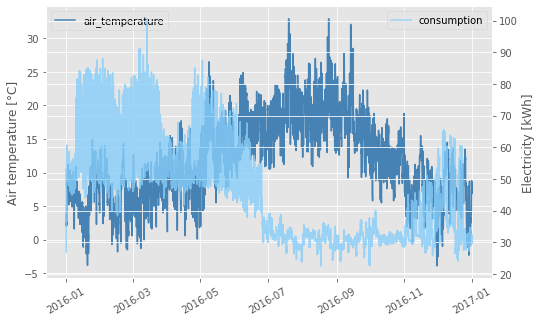

In [19]:
# total energy onsumption vs. air temperature
id_to_plot = 135

sample = df[df['building_id'] == id_to_plot]  # same train sample as above

fig, ax = plt.subplots(figsize=(8,5))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()

dates = sample.index
ax2.plot_date(dates, 
              sample['meter_reading'], 
              '-', 
              color='lightskyblue', 
              label='consumption', 
              alpha=0.8)
ax.plot_date(dates, 
             sample['air_temperature'], 
             '-', 
             color='steelblue', 
             label='air_temperature')
ax.set_ylabel('Air temperature [°C]'); ax2.set_ylabel('Electricity [kWh]')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')
# fig.savefig('id_135.png')
# files.download("id_135.png")

The previous figure shows the yearly behaviour of electricity consumption vs. air temperature over 2016 for building 135. The relationship between these variables seems negative. This can be interpreted as when the temperature decreases, the need for electrical heating increases for that specific building. Notice that this was a chosen building at an specific site; other buildings at other sites may show a different behaviour (maybe even the opposite).

In [20]:
df.site_id.unique()

array([ 0,  1,  2,  3,  4,  6,  9, 10, 13, 14, 15], dtype=int8)

The following three cells show an overview of the hourly consumption for each building, the color represents the site_id they belong to. 

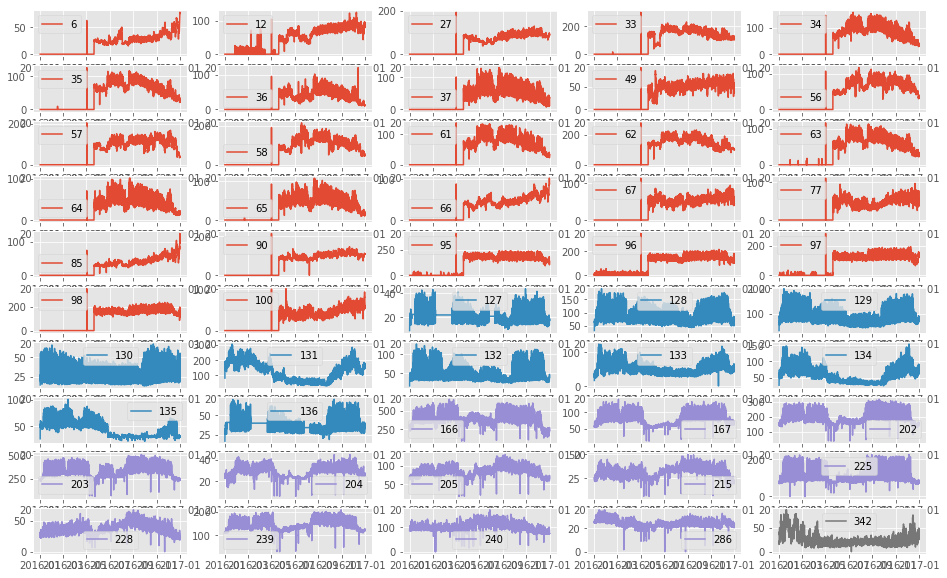

In [21]:
for i in range(1, 51):
    plt.subplot(10, 5, i)
    sample = df[df['building_id'] == df.building_id.unique()[i-1]] 
    dates = sample.index
    plt.plot(dates,
             sample['meter_reading'],
             color='C'+str(sample.site_id[0]),
             label=str(df.building_id.unique()[i-1]))
    plt.legend()

In the previous figure, we can see that the red-colored buildings don't have any measurements in the first third of the dataset. While the purple-colored buildings have extreme peaks and zero measurements.

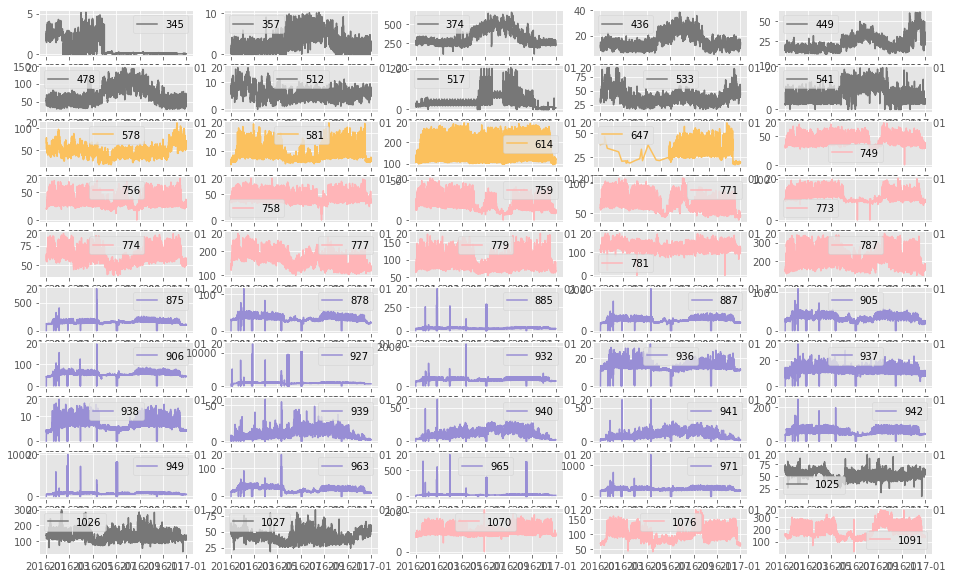

In [22]:
for i in range(51, 101):
    plt.subplot(10, 5, i-50)
    sample = df[df['building_id'] == df.building_id.unique()[i-1]] 
    dates = sample.index
    plt.plot(dates,
             sample['meter_reading'],
             color='C'+str(sample.site_id[0]),
             label=str(df.building_id.unique()[i-1]))
    plt.legend()

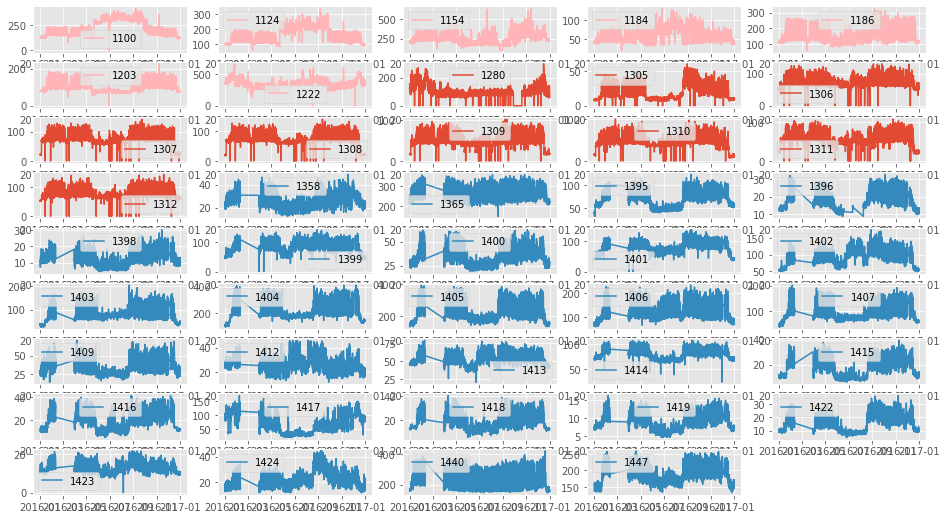

In [23]:
for i in range(101, 145):
    plt.subplot(10, 5, i-100)
    sample = df[df['building_id'] == df.building_id.unique()[i-1]] 
    dates = sample.index
    plt.plot(dates,
             sample['meter_reading'],
             color='C'+str(sample.site_id[0]),
             label=str(df.building_id.unique()[i-1]))
    plt.legend()

The following figure plots the buildings that have the complete measurements, i.e. 8784 hours with measurements.

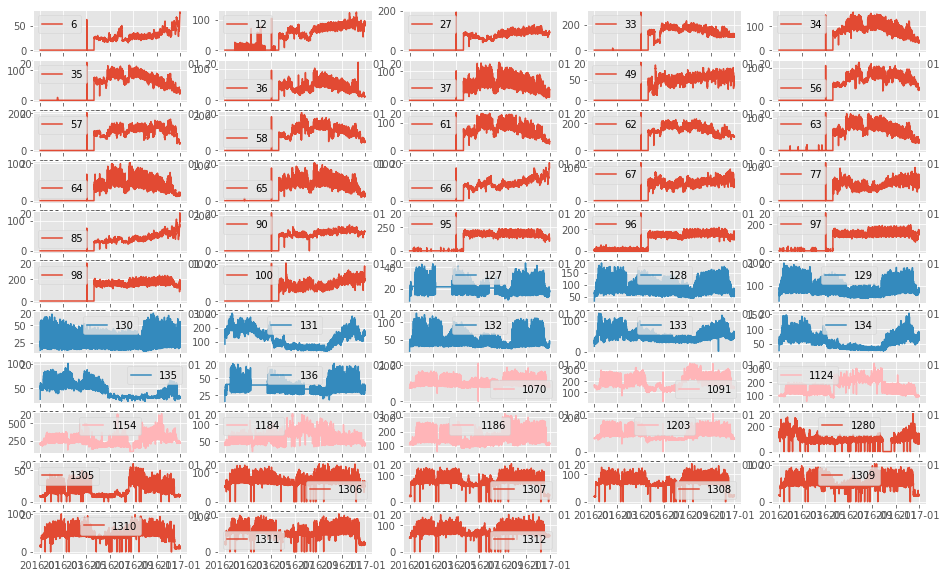

In [24]:
# Buildings with complete measurements
for i in range(1, 54):
    plt.subplot(11, 5, i)
    sample = df[df['building_id'] == complete_ids[i-1]] 
    dates = sample.index
    plt.plot(dates,
             sample['meter_reading'],
             color='C'+str(sample.site_id[0]),
             label=str(complete_ids[i-1]))
    plt.legend()

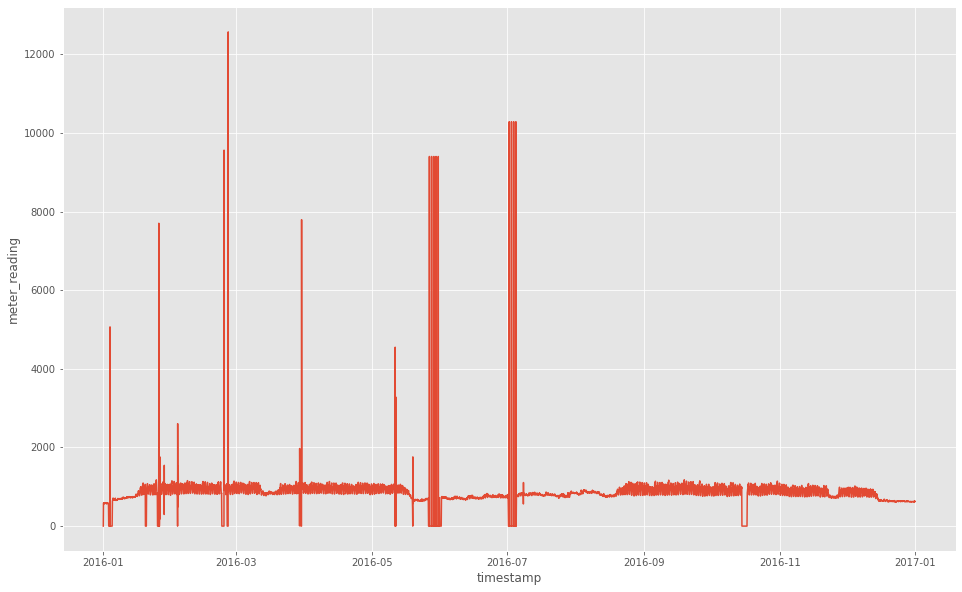

In [25]:
# Weird buildings -> high mean and variance
id_to_plot = 927 #927, 932, 971
sample = df[df['building_id'] == id_to_plot] 
dates = sample.index
sns.lineplot(dates, sample['meter_reading'])

Text(0, 0.5, 'Building ID (Variance)')

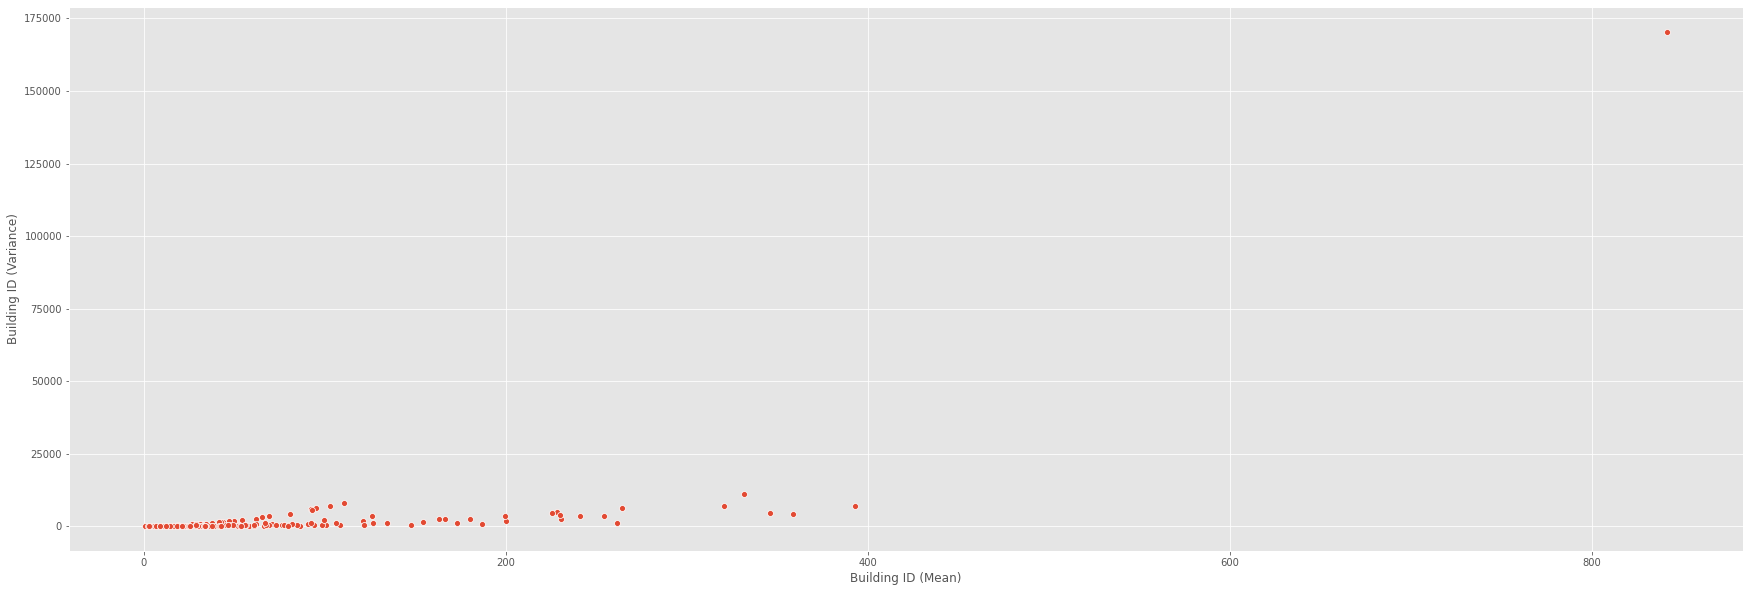

In [26]:
# Mean vs Variance -> 927 is at the upper right corner (clearly an outlier)
plt.figure(figsize=(30,10))
sns.scatterplot(df_mean.meter_reading, df_var.meter_reading)
plt.xlabel('Building ID (Mean)')
plt.ylabel('Building ID (Variance)')

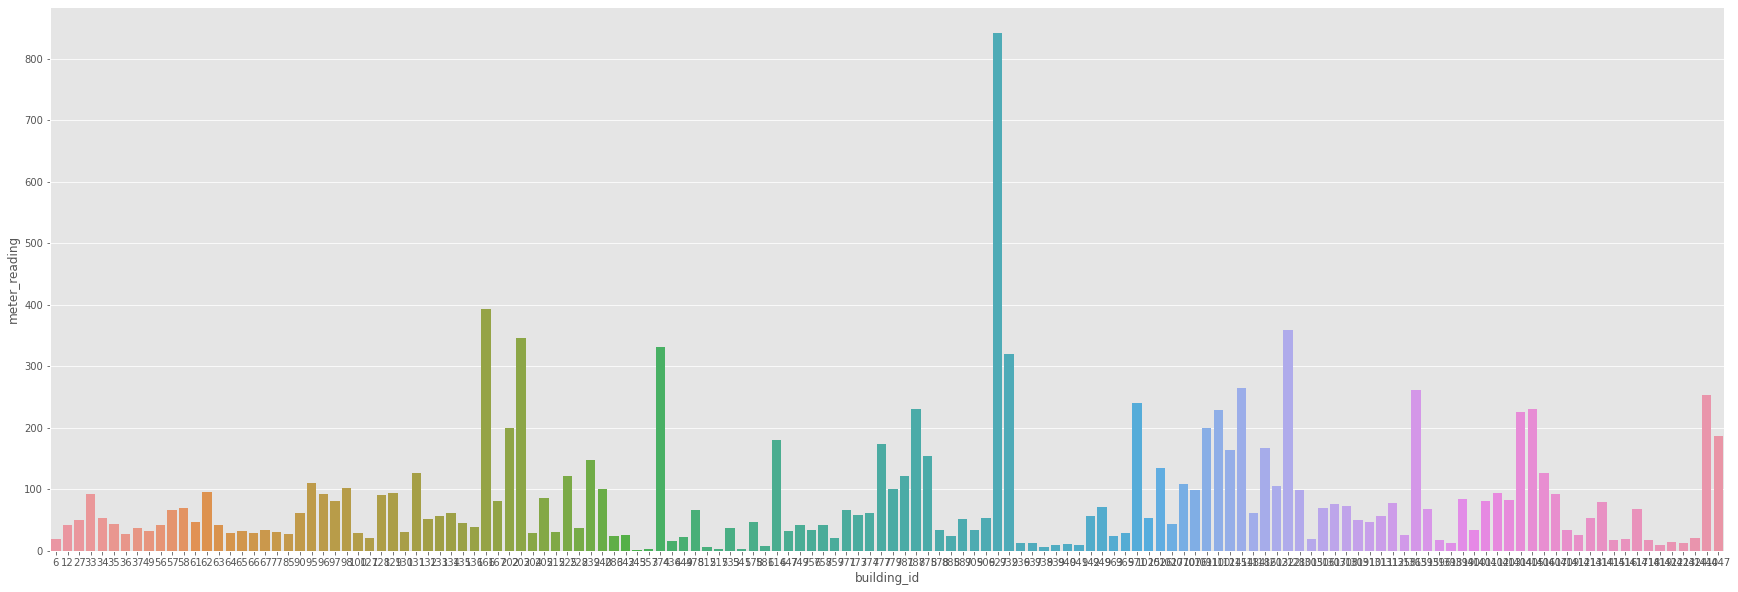

In [27]:
# Yearly mean consumption per building
plt.figure(figsize=(30,10))
sns.barplot(df_mean.index, df_mean.meter_reading)

# Modelling
Here we start our modelling. Building 131 is selected for the individual forecast and we define that we wish to forecast 24 steps, ie. one day in advance. The following cell is the most important one, it serves as a cockpit for the modelling, if a new run is desired, start from the following cell and follow these steps:
- Select day to forecast (we used 2016-02-01 (Feb 1, 2016) and 2016-07-01 (July 1, 2016) to show the performance of the different models when training with more data.
- Select forecast steps, our initial research question is 24 hours but it is also interesting to see the performance of the models when forecasting more than 24 hours. Notice that LR and BLR don't work if the forecast steps are too long, since the beta parameters will be zero if you haven't trained an specific week.
- Set complete_buildings to true if you want to drop the buildings without complete measurements, set to True for now (False should be future work). Therefore, we filter the 145 buildings to just use 54.
- Set all_buildings to True if you want to forecast all the buildings, in this case only LR, BLR and HM should be used, LDS only work for a single selected building.
- Set selected_building to an specific building id. We recommend 131 since this building consumption pattern works as a base model.

In [0]:
# Select general parameters
forecast_day = '2016-02-01' # Format: 'yyyy-mm-dd', equivalent to train %
forecast_steps = 24 # Forecast time steps in hours

complete_buildings = True # Drop buildings with uncomplete measurements (always True)
all_buildings = False # If True forecast all buildings, else False (+ selected_building)

# Select building_id or site_id to model
selected_building = 131 # 131 recommended, only used if all_buildings = False

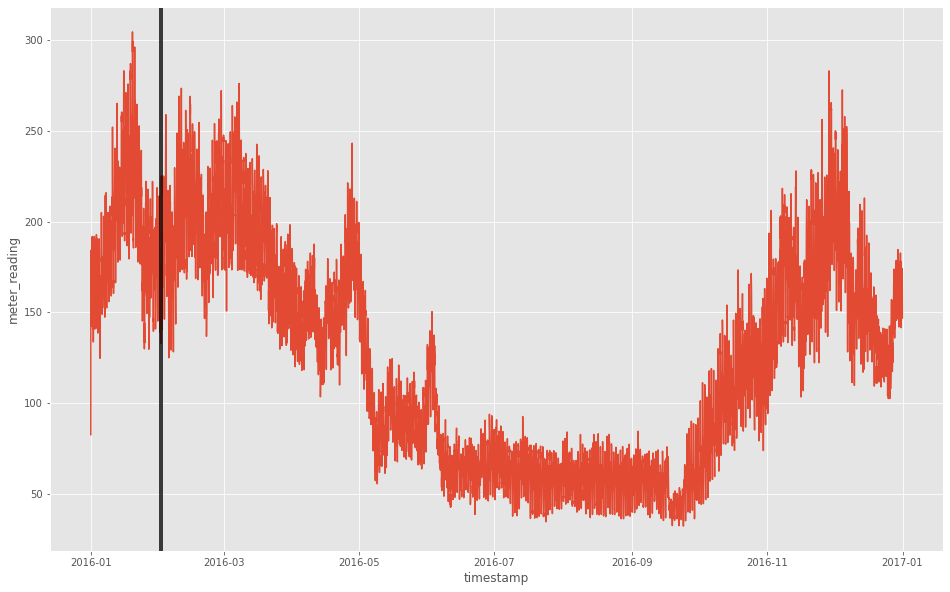

In [265]:
# Building to forecast
sample = df[df['building_id'] == selected_building] 
dates = sample.index
sns.lineplot(dates, sample['meter_reading'])
plt.axvline(pd.to_datetime(forecast_day), c='k')
plt.axvline(pd.to_datetime(forecast_day) + dt.timedelta(hours=forecast_steps), c='k')

We did an interpolation of the missing values in the X matrix. We tried to make the imputation with the bayesian models (LDS) but it was very troublesome. At the end, we decided to interpolate the values and focus on modelling different types of LDS instead.

In [0]:
# Select complete buildings and interpolate missing X values
if complete_buildings:
    df_interp = df[df.building_id.isin(complete_ids)].copy()
    df_interp.interpolate(inplace=True)
else:
    df_interp = df.copy()
    df_interp.interpolate(inplace=True)

## Feature selection

Here we add the hour, day of the week and week features from the timestamp. Intuitively power consumption should change in households depending on the hour of the day, and during weekends and vacation weeks. Hence, we one-hot-encode these features as well as the site_id and building_id features, i.e. the categorical features. Subsequently, we scale the rest of the features by subtracting the mean and dividing by the standard deviation.

We use three different X-matrices, one for regression and bayesian linear regression. Another one for the hierarchical model, which is the same as the linear regression X-matrix but exlcudes the categorical features of site_id. Finally, the temporal models only include the weather variables and ignores all the others. This was required to run all the models consecutively and avoid errors as well.

### Regression

In [0]:
# Add time-wise features
if all_buildings:
    df_reg = df_interp.copy()
    # df_reg = df_interp.sample(frac=0.1).copy()
else:
    df_reg = df_interp[df_interp.building_id==selected_building].copy() # filter building_id

df_reg['week'] = df_reg.index.week
df_reg['day'] =  df_reg.index.weekday
df_reg['hour'] =  df_reg.index.hour
df_reg = df_reg.astype({'square_feet': 'float32',
                        'air_temperature': 'float32',
                        'dew_temperature': 'float32',
                        'sea_level_pressure': 'float32'})

In [268]:
df_reg.head()

building_id  meter_reading  site_id  ...  week  day  hour
timestamp                                                 ...                 
2016-01-01 00:00:00          131         82.599        1  ...    53    4     0
2016-01-01 01:00:00          131        184.297        1  ...    53    4     1
2016-01-01 02:00:00          131        179.697        1  ...    53    4     2
2016-01-01 03:00:00          131        167.697        1  ...    53    4     3
2016-01-01 04:00:00          131        155.297        1  ...    53    4     4

[5 rows x 11 columns]

In [0]:
# Prepare features matrix
X_time = np.concatenate([pd.get_dummies(df_reg[x]) for x in ["week", "day", "hour"]],
                            axis=1)
if all_buildings:
    X_building_id = pd.get_dummies(df_reg.building_id)
    X_site_id = pd.get_dummies(df_reg.site_id)
    X_rest = df_reg.drop(
        columns=['building_id', 'meter_reading', 'site_id', 'week', 'day', 'hour'])
    
    # Scale X_rest
    X_rest -= X_rest.mean()
    X_rest /= X_rest.std()

    # Join matrices
    X = np.concatenate([X_rest, X_building_id, X_site_id, X_time], axis=1)
    Xh = np.concatenate([X_rest, X_building_id, X_time], axis=1) # without X_site_id
else:
    X_rest = df_reg.drop(
        columns=['building_id', 'meter_reading', 'site_id', 'square_feet',
                 'week', 'day', 'hour']) # square_feet removed (constant for 1 building)
    # Scale X_rest
    X_rest -= X_rest.mean()
    X_rest /= X_rest.std()

    # Join matrices
    X = np.concatenate([X_rest, X_time], axis=1)

In [0]:
# Transform target variable
y = df_reg.meter_reading.values
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean)/y_std

### Temporal

In [0]:
# Full DataFrame for temporal models (only for one building for now, future work)
if all_buildings:
    df_temporal = df_interp[df_interp.building_id == selected_building].copy() # future work
else:
    df_temporal = df_interp[df_interp.building_id == selected_building].copy()
df_temporal = df_temporal.astype({'square_feet': 'float32',
                                  'air_temperature': 'float32',
                                  'dew_temperature': 'float32',
                                  'sea_level_pressure': 'float32'})

In [0]:
# Prepare features matrix
if all_buildings:
    # Xt_building_id = pd.get_dummies(df_temporal.building_id)
    # Xt_site_id = pd.get_dummies(df_temporal.site_id)
    Xt_rest = df_temporal.drop(
        columns=['building_id', 'meter_reading', 'site_id', 'square_feet']) # square_feet

    # Scale X_rest
    Xt_rest -= Xt_rest.mean(skipna=True)
    Xt_rest /= Xt_rest.std(skipna=True)

    # Join matrices
    # Xt = np.concatenate([Xt_rest, X_building_id, X_site_id], axis=1)
    Xt = Xt_rest.values
else:
    Xt_rest = df_temporal.drop(
        columns=['building_id', 'meter_reading', 'site_id', 'square_feet'])
    
    # Scale X_rest
    Xt_rest -= Xt_rest.mean(skipna=True)
    Xt_rest /= Xt_rest.std(skipna=True)

    # Join matrices
    Xt = Xt_rest.values

In [0]:
# Transform target variable
yt = df_temporal.meter_reading.values
yt_mean = yt.mean()
yt_std = yt.std()
yt = (yt - yt_mean) / yt_std

In [274]:
# Sanity-check for missing measurements
clean_idx.difference(df_temporal.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

## Parameters and matrices
Here we prepare the parameters and matrices for our models and get an overview of the observations and features.

In [275]:
# Select training weeks and general info
N, M = X.shape
Nt, Mt = Xt.shape
print('Regression models')
print('Total observations: %i' % N)
print('Features: %i\n' % M)
if all_buildings:
    Nh, Mh = Xh.shape
    print('Hierarchical model')
    print('Total observations: %i' % Nh)
    print('Features: %i\n' % Mh)
else:
    print('Temporal models')
    print('Total observations: %i' % Nt)
    print('Features: %i' % Mt)

Regression models
Total observations: 8784
Features: 88

Temporal models
Total observations: 8784
Features: 4


In [276]:
# Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y)

forecast_dates = pd.date_range(pd.to_datetime(forecast_day),
                                pd.to_datetime(forecast_day) + dt.timedelta(
                                    hours=forecast_steps),
                                freq='H',
                                closed='left')

if all_buildings:
    ix_train = df_reg.index < pd.to_datetime(forecast_day) # no permutation
    ix_test = df_reg.index.isin(forecast_dates)

    X_train = X[ix_train,:]
    X_test = X[ix_test,:]
    Xh_train = Xh[ix_train,:]
    Xh_test = Xh[ix_test,:]
    # Xt_train = Xt[ix_train,:]
    # Xt_test = Xt[ix_test,:]

    y_train = y[ix_train]
    y_test = y[ix_test]
    # yt_train = yt[ix_train]
    # yt_test = yt[ix_test]

    N_train = len(y_train)
    N_test = len(y_test)
    # Nt_train = len(yt_train)
    # Nt_test = len(yt_test)

    # Create a mapping between building_ids and individual ids
    mapping = {key: value for value, key in enumerate(set(df_reg.building_id))}
    inds = torch.LongTensor([mapping[h_id] for h_id in df_reg.building_id])
    ind_train = inds[ix_train]
    ind_test = inds[ix_test]

    # Create a mapping for site_id
    site_mapping = {key: value for value, key in enumerate(set(df_reg.site_id))}
    sites = torch.LongTensor([site_mapping[h_id] for h_id in df_reg.site_id])
    sites_train = sites[ix_train]
    sites_test = sites[ix_test]
else:
    split_point = df_reg.index.get_loc(pd.to_datetime(forecast_day))
    split_point_t = df_temporal.index.get_loc(pd.to_datetime(forecast_day))

    ix_train = np.random.permutation(split_point) # permute only for lr and blr models
    ix_test = range(split_point, split_point + forecast_steps)
    ixt_train = range(0, split_point_t)
    ixt_test = range(split_point_t, split_point_t + forecast_steps)

    X_train = X[ix_train,:]
    X_test = X[ix_test,:]
    Xt_train = Xt[ixt_train,:]
    Xt_test = Xt[ixt_test,:]

    y_train = y[ix_train]
    y_test = y[ix_test]
    yt_train = yt[ixt_train]
    yt_test = yt[ixt_test]

    N_train = len(y_train)
    N_test = len(y_test)
    Nt_train = len(yt_train)
    Nt_test = len(yt_test)

print('Regression models')
print("Train observations: %d" % N_train)
print("Test observations: %d\n" % N_test)
if all_buildings:
    print('Hierarchical models')
    print("Train observations: %d" % N_train)
    print("Test observations: %d\n" % N_test)
else:
    print('Temporal models')
    print("Train observations: %d" % Nt_train)
    print("Test observations: %d" % Nt_test)

Regression models
Train observations: 744
Test observations: 24

Temporal models
Train observations: 744
Test observations: 24


In [0]:
# True values
y_true = y_test * y_std + y_mean
if not all_buildings:
    yt_true = yt_test * yt_std + yt_mean

## Linear Regression
Here we run a vanilla linear regression to have as a reference. Notice the huge amount of beta parameters given the categorical variables, these work essentially as extra intercepts (by summing $\beta_0$ + $\beta_{categorical}$). For example, if an observation occurs in week 24, day 1 (monday), and hour 6, then all the other beta parameters related to the other weeks, days, and hours are 0; while the beta parameters related to the timestamp when the observation happens are 1. Therefore, we have in theory one model to forecast for each unique combination of building_id, site_id, week, day, and hour.

Given the dataset $\mathcal{D} = \{x_n,y_n\}_{n=1}^N$, where for each input point $x_n$ we have a corresponding target $y_n$. The linear regression model equation is:
\begin{align}
y_n = \beta_0 + \beta^T x_n + \epsilon_n,
\end{align}

where $\beta_0$ is the intercept, $\beta$ the parameter related to each feature in the $X$ matrix, and $\epsilon_n$ the error.

In [0]:
# Fit model
lr = Ridge()
lr.fit(X_train, y_train)

# Obtain estimates
preds_lr = lr.predict(X_test) # estimates

# Convert back to the original scale
y_hat_lr = preds_lr * y_std + y_mean

In [279]:
# Coefficients
coefs = np.concatenate([[lr.intercept_],lr.coef_])
for i, coef in enumerate(coefs):
    print('β_%i: %.6f' %(i, coef))

β_0: 0.739692
β_1: -0.371201
β_2: -0.083461
β_3: 0.032478
β_4: 0.062766
β_5: -0.133644
β_6: 0.247608
β_7: 0.325782
β_8: -0.089225
β_9: 0.000000
β_10: 0.000000
β_11: 0.000000
β_12: 0.000000
β_13: 0.000000
β_14: 0.000000
β_15: 0.000000
β_16: 0.000000
β_17: 0.000000
β_18: 0.000000
β_19: 0.000000
β_20: 0.000000
β_21: 0.000000
β_22: 0.000000
β_23: 0.000000
β_24: 0.000000
β_25: 0.000000
β_26: 0.000000
β_27: 0.000000
β_28: 0.000000
β_29: 0.000000
β_30: 0.000000
β_31: 0.000000
β_32: 0.000000
β_33: 0.000000
β_34: 0.000000
β_35: 0.000000
β_36: 0.000000
β_37: 0.000000
β_38: 0.000000
β_39: 0.000000
β_40: 0.000000
β_41: 0.000000
β_42: 0.000000
β_43: 0.000000
β_44: 0.000000
β_45: 0.000000
β_46: 0.000000
β_47: 0.000000
β_48: 0.000000
β_49: 0.000000
β_50: 0.000000
β_51: 0.000000
β_52: 0.000000
β_53: 0.000000
β_54: 0.000000
β_55: 0.000000
β_56: 0.000000
β_57: -0.350430
β_58: -0.004825
β_59: -0.033202
β_60: -0.054039
β_61: -0.022438
β_62: -0.002129
β_63: 0.026415
β_64: 0.090211
β_65: 0.019407
β_66: 0.06

In [280]:
compute_error(y_true, y_hat_lr)

[0.7680184983019014, 14.394356, 0.70020676, 19.494806, 0.38234448432922363]

## Bayesian Linear Regression
Here we run inference on our first bayesian model. This is equivalent to the previous "normal" linear regression, but we give the following priors to the model ($\mu$ at zero and $\sigma$ at 5 to give the model some "freedom" when adjusting the posterior distribution of the latent variable, relates to the information we give to the model with the prior):

\begin{equation}
    \beta \sim \mathcal{N}(\mathbf{\mu},\mathbf{\sigma})
\end{equation}
\begin{equation}
        \alpha \sim \mathcal{N}(\mathbf{\mu},\mathbf{\sigma})
\end{equation}
\begin{equation}
    y \sim \mathcal{N}(\alpha + \beta \cdot \mathbf{X}, \mathbf{\sigma})
\end{equation}
Given these assumption we use the following generative process:
1. Draw coefficients $\alpha \sim \mathcal{N}(\alpha \mid 0, 5)$
2. Draw coefficients $\beta \sim \mathcal{N}(\beta \mid \mathbf{0}, 5 \mathbf{I})$
3. For each feature vector $X_n$
    - Draw target $y_n \sim \mathcal{N}(y_n \mid \alpha + \beta^T \cdot \mathbf{X_n}, \sigma^2)$

The factorized joint distribution is:
\begin{equation}
        p(\alpha, \mathbf{\beta},\mathbf{y_n}\mid  \mathbf{X_n}, \mathbf{\mu},\mathbf{\sigma})=p(\mathbf{\beta} \mid \mathbf{\mu},\mathbf{\sigma})p(\alpha \mid \mathbf{\mu},\mathbf{\sigma}) \prod_{n=1}^{N}p(\mathbf{y_n} \mid \alpha, \mathbf{\beta}, \mathbf{X_n}, \sigma)
\end{equation}

We used SVI in this model with 10000 steps and 0.001 as the learning rate for Clipped Adam optimizer.

In [0]:
# Convert to Tensor
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()
X_test_torch = torch.tensor(X_test).float()
y_test_torch = torch.tensor(y_test).float()

# Define guide function
guide = pyro.contrib.autoguide.AutoMultivariateNormal(model_blr)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = pyro.optim.ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = pyro.infer.Trace_ELBO(num_particles=1)
svi = pyro.infer.SVI(model_blr, guide, optimizer, loss=elbo)

In [282]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 3197.2
[1000] ELBO: 2260.7
[2000] ELBO: 1514.8
[3000] ELBO: 1016.5
[4000] ELBO: 354.2
[5000] ELBO: 201.9
[6000] ELBO: 217.3
[7000] ELBO: 191.4
[8000] ELBO: 190.4
[9000] ELBO: 286.9


In [0]:
# Use predictive from pyro
predictive = pyro.infer.Predictive(model_blr, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_test_torch)

# Get samples and estimates
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
preds_blr = np.mean(alpha_samples.T + np.dot(X_test, beta_samples.T), axis=1)

# Convert back to the original scale
y_hat_blr = preds_blr * y_std + y_mean

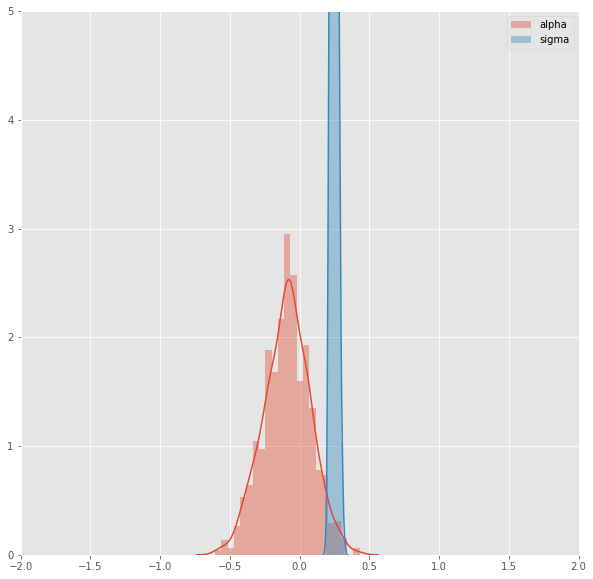

In [284]:
# Intercept and error
plt.figure(figsize=(10,10))
sns.distplot(alpha_samples)
sns.distplot(samples["sigma"].detach().numpy())
plt.legend(["alpha", "sigma"])
plt.axis([-2,2,0,5]);

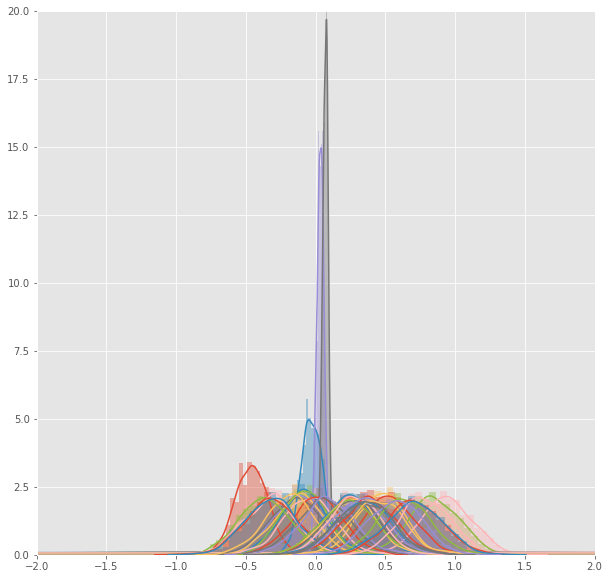

In [285]:
# Beta parameters
plt.figure(figsize=(10,10))
for i in range(M):
    sns.distplot(beta_samples[:, i])
#plt.legend(["beta%d" % i for i in range(M)])
plt.axis([-2,2,0,20])
plt.show()

In [286]:
compute_error(y_true, y_hat_blr)

[0.7496476530818819, 37.43211, 1.8208677, 40.979385, 0]

## Hierarchical Model

 Notice that this model should be run ONLY when all_buildings is set to true, i.e. it shouldn't be run for a single building because the hierarchy depends on the site.

Here we run inference on our hierarchical model. The hierarchical model, is based on the concept of hierarchical regression. The dataset consists of multiple observations from various sites. In comparison to a vanilla regression model, where the bias for each attribute is the same for all sites, in this model we allow different sites to have different biases. So given number of sites we have ($\textbf{site}$):

\begin{equation}
    \beta \sim \mathcal{N}(\mathbf{\mu},\mathbf{\sigma})
\end{equation}
\begin{equation}
        \mathbf{\alpha} \sim \mathcal{N}(\mathbf{\mu}\mid \text{site},\mathbf{\sigma})
\end{equation}
\begin{equation}
    y \sim \mathcal{N}(\alpha + \beta \cdot \mathbf{X}\mid \text{site}, \mathbf{\sigma})
\end{equation}

Given these assumptions the generative process for our hierarchical model is:
1. Draw coefficients $\beta \sim \mathcal{N}(\beta \mid \mathbf{0}, \lambda \mathbf{I})$
2. Draw coefficients $\alpha_\mu \sim \mathcal{N}(\alpha_\mu \mid \mathbf{0}, \lambda \mathbf{I})$
3. Draw coefficients $\alpha_\sigma \sim \textit{HalfCauchy}(\alpha_\sigma \mid \mathbf{5})$
4. For each $\textbf{site}$
    - Draw bias $\alpha_{\text{site}} \sim \mathcal{N}(\alpha_\mu, \alpha_\sigma)$
5. For each feature vector $\mathbf{X_n}$
    - Draw target $y_n \sim \mathcal{N}(y_n \mid \beta^T \cdot \mathbf{X_n}, \sigma^2)$

The factorized joint distribution of this model is:

\begin{equation}
        p(\alpha, \beta,\mathbf{y_n} \mid  \mathbf{X_n})=
        p(\alpha)p(\alpha_\sigma)p(\beta )p(\sigma) (\prod_{site=1}^{S}p(\mathbf{\alpha} \mid \alpha_\mu, \alpha_\sigma))\prod_{n=1}^{N}p(\mathbf{y} \mid \alpha_{site}+\beta^T \cdot X_n, \sigma)
\end{equation}

In [0]:
# Parameters
n_households = len(df_reg.building_id.unique())
n_sites = len(set(df_reg.site_id))

# Convert to Tensor
X_train_torch = torch.tensor(Xh_train).float()
y_train_torch = torch.tensor(y_train).float()
X_test_torch = torch.tensor(Xh_test).float()
y_test_torch = torch.tensor(y_test).float()

In [229]:
# Define guide function
guide = pyro.contrib.autoguide.AutoMultivariateNormal(model_hm)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = pyro.optim.ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = pyro.infer.Trace_ELBO(num_particles=1)
svi = pyro.infer.SVI(model_hm, guide, optimizer, loss=elbo)

# Do gradient steps
for step in tqdm(range(n_steps)):
    elbo = svi.step(X_train_torch,
                    ind_train,
                    n_households,
                    sites_train,
                    n_sites,
                    y_train_torch)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 191256.0
[1000] ELBO: 103271.5
[2000] ELBO: 62767.9
[3000] ELBO: 45362.8
[4000] ELBO: 34801.4
[5000] ELBO: 30896.5
[6000] ELBO: 19322.6
[7000] ELBO: 43290.1
[8000] ELBO: 37290.8
[9000] ELBO: 25526.1
[10000] ELBO: 35851.5
[11000] ELBO: 30577.8
[12000] ELBO: 17012.0
[13000] ELBO: 14989.6
[14000] ELBO: 13094.7
[15000] ELBO: 25908.8
[16000] ELBO: 48185.6
[17000] ELBO: 34796.8
[18000] ELBO: 15541.0
[19000] ELBO: 18610.7



In [0]:
predictive_hm = pyro.infer.Predictive(model=model_hm,
                                      guide=guide,
                                      num_samples=1000,
                                      return_sites=("beta",
                                                    "alpha",
                                                    "alpha_mu",
                                                    "alpha_sigma"))
samples_hm = predictive_hm(X_train_torch,
                           ind_train,
                           n_households,
                           sites_train,
                           n_sites,
                           y_train_torch)

# Extract expected values of the parameters
beta_samples = samples_hm["beta"].detach().numpy()
alpha_samples = samples_hm["alpha"].detach().numpy()
alpha_mu_samples = samples_hm["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples_hm["alpha_sigma"].detach().numpy()
alpha_hat = samples_hm["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples_hm["beta"].mean(axis=0).detach().numpy()

# Make predictions for test set
preds_hm = alpha_hat[sites_test] + np.dot(Xh_test, beta_hat.T)

# Convert back to the original scale
y_hat_hm = preds_hm * y_std + y_mean

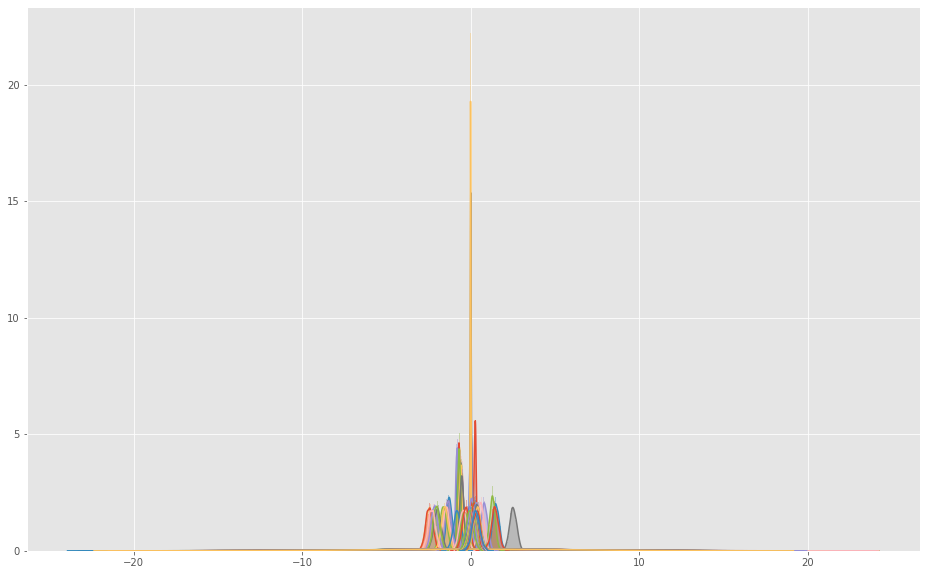

In [231]:
for i in range(Xh.shape[1]):
    sns.distplot(beta_samples[:,i])

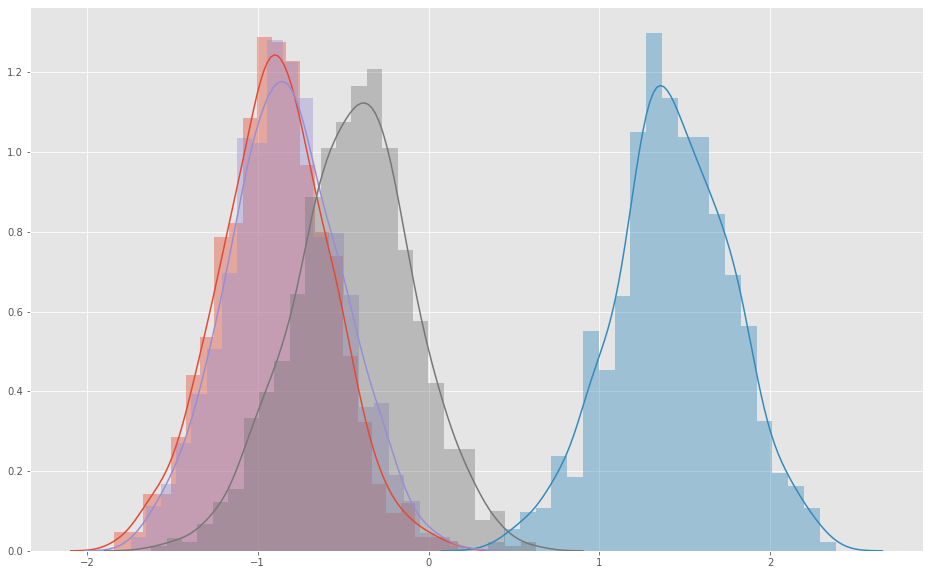

In [232]:
for i in range(n_sites):
    sns.distplot(alpha_samples[:,i])

In [233]:
compute_error(y_true, y_hat_hm)

[0.9586581442413464, 11.906635, 0.22653466, 20.016226, 0.9129746183753014]

## Linear Dynamical Systems (LDS)
Here we run inference on all our Linear Dynamical Systems using MCMC and numpyro. For the diagnostics, we look into the number of effective samples per variable and r_hat value (1.00 should a good number). Also, we use trace plots for looking at the convergence and exploration of the markov chain in the important variables.

The temporal models (linear dynamical systems) investigated are a variety of linear dynamic auto regressive models. Including lag 1-168, and with/without the weather data as an input. Notice that for LDS-AR24 and LDS-AR168 with and without weather inputs, only beta parameters 1, 24, and 168 are used, not the whole lags between $t-1$ and $t-24$ or $t-168$, respectively.

The following generative process works as a general guideline that works for all LDS models, it is the LDS AR1 process but also works for LDS-AR2, LDS-AR24 and LDS-AR168 with and without inputs, only that we're including an extra $\beta$ for each model, i.e. AR2 includes two $\beta$ latent variables, AR24 includes $\beta_1$ and $\beta_{24}$ only (no beta latent variables between 2 and 23), and AR168 includes $\beta_1$, $\beta_{24}$, and $\beta_{168}$ (no beta latent variables between 2 and 24, and 25 and 167). We decided to do this to speed-up the calculations and also makes sense in that we're giving the current state $t$ the information from 1 hour before, 2 hours before, 1 hour and 24 hours before (for AR24), and 1 hour, 24 hours and 168 hours before (for AR168, i.e. a day and a week before).

For the step size, we let the NUTS algorithm to calculate the optimal step size to obtain an acc. probability of 0.8 since these runs were better performing compared to our own selection of step sizes, see: http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf. 

LDS-AR without weather inputs:

\begin{equation}
p(y_{t}\mid y_{t-1}, \beta, \sigma)=
        p(\beta )\prod_{t=1}^{T}p(y_{t}\mid \beta y_{t-1}, \sigma)
\end{equation}

1. Draw coefficients $\delta \sim \mathcal{N}(\beta \mid \mathbf{0}, \lambda \mathbf{I})$
2. Draw coefficients $\text{R} \sim \textit{HalfCauchy}(\alpha_\sigma \mid \mathbf{5})$
3. For each timestep $t \in {2,...,T}$
    - Draw  $h_t \sim \mathcal{N}(h_t \mid \delta_1y_{t-1} , R^2)$
4. For each timestep $t \in {1,...,T}$
    - Draw target $y_t \sim \mathcal{N}(y_t \mid \beta^T \cdot \mathbf{h_t}, \sigma^2)$

LDS-ARx with weather inputs:

\begin{equation}
p(y_{t}\mid y_{t-1}, \beta, \sigma)=
        p(\beta )\prod_{t=1}^{T}p(y_{t}\mid \beta y_{t-1} + eta \cdot x_{t-1}, \sigma)
\end{equation}

1. Draw coefficients $\delta \sim \mathcal{N}(\beta \mid \mathbf{0}, \lambda \mathbf{I})$
2. Draw coefficients $\text{R} \sim \textit{HalfCauchy}(\alpha_\sigma \mid \mathbf{5})$
3. For each timestep $t \in {2,...,T}$
    - Draw  $h_t \sim \mathcal{N}(h_t \mid \delta_1 y_{t-1} + \eta \mathbf{x}_{t-1} , R^2)$
4. For each timestep $t \in {1,...,T}$
    - Draw target $y_t \sim \mathcal{N}(y_t \mid \beta^T \cdot \mathbf{h_t}, \sigma^2)$

In [0]:
# numpyro.set_host_device_count(2) to change num_chains - makes get_samples VERY slow, avoid

### AR1

In [287]:
# Start time
tic = time.time()

# Run MCMC
nuts_kernel = NUTS(model=model_AR1, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR1, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [01:22<00:00, 48.48it/s, 255 steps of size 2.84e-03. acc. prob=0.71]


Total time: 1.453m


In [288]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.98      0.01      0.98      0.97      0.99     41.71      1.03
  noises[0]      6.54      0.36      6.56      5.99      7.16     75.24      1.01
  noises[1]      0.03      0.31      0.02     -0.44      0.58    144.35      1.00
  noises[2]     -0.74      0.29     -0.74     -1.21     -0.26    446.54      1.00
  noises[3]     -0.77      0.29     -0.78     -1.24     -0.32    364.41      1.01
  noises[4]      1.05      0.30      1.06      0.58      1.54    258.11      1.00
  noises[5]     -0.37      0.29     -0.39     -0.91      0.09    160.27      1.00
  noises[6]     -1.35      0.30     -1.36     -1.85     -0.89    229.34      1.00
  noises[7]      1.71      0.33      1.74      1.18      2.21     61.44      1.01
  noises[8]     -0.56      0.33     -0.56     -1.12     -0.05     51.71      1.01
  noises[9]      0.84      0.31      0.84      0.38      1.40    154.01      1.00
 noises[10]    

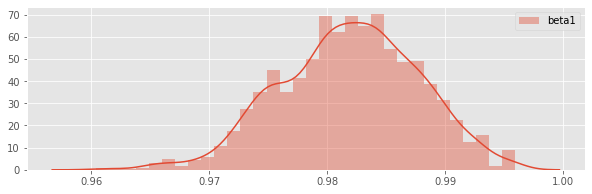

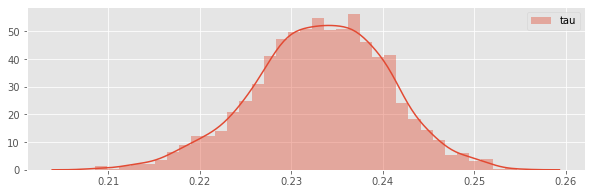

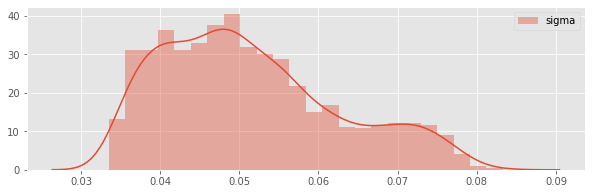

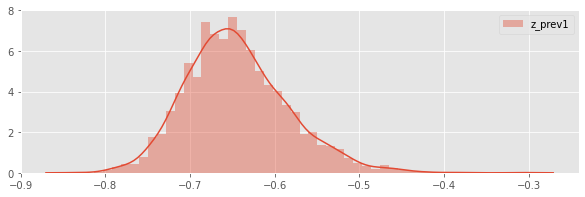

In [289]:
# Get parameter samples
hmc_samples_ar1 = mcmc.get_samples()
nodes_ar1 = ["beta1", "tau", "sigma", "z_prev1"]
for node in nodes_ar1:
    plt.figure(figsize=(10,3))
    sns.distplot(hmc_samples_ar1[node], label=node)
    plt.legend()
    plt.show()

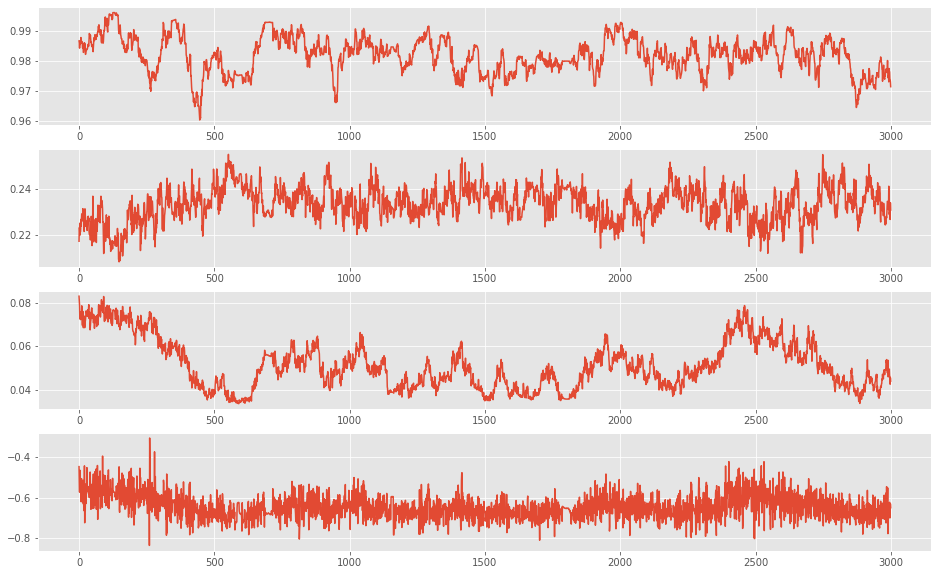

In [290]:
# Trace plot
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
ax1.plot(hmc_samples_ar1['beta1'])
ax2.plot(hmc_samples_ar1['tau'])
ax3.plot(hmc_samples_ar1['sigma'])
ax4.plot(hmc_samples_ar1['z_prev1'])

In [0]:
# Get predictions
y_hat_ar1 = compute_predictions(hmc_samples_ar1["y_hat"], yt_std, yt_mean)

In [292]:
compute_error(yt_true, y_hat_ar1)

[-0.38410404538869614, 26.374079, 1.2829548, 29.76134, 0]

### AR2

In [293]:
# Start time
tic = time.time()

# Run MCMC
nuts_kernel = NUTS(model=model_AR2, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR2, max_tree_depth=8, step_size=5e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [01:36<00:00, 41.42it/s, 255 steps of size 3.15e-04. acc. prob=0.91]


Total time: 1.778m


In [294]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      1.03      0.08      1.03      0.89      1.13      2.66      2.17
      beta2     -0.03      0.08     -0.03     -0.13      0.11      2.66      2.17
  noises[0]      0.32      0.17      0.32      0.06      0.57      9.39      1.29
  noises[1]      0.53      0.76      0.34     -0.51      1.64      2.74      2.55
  noises[2]     -0.08      0.02     -0.08     -0.11     -0.04      6.43      1.11
  noises[3]      0.13      0.67      0.35     -0.85      0.98      2.45      2.89
  noises[4]     -0.36      0.08     -0.37     -0.48     -0.24      7.45      1.01
  noises[5]      1.81      0.03      1.81      1.76      1.88      6.94      1.12
  noises[6]     -0.31      0.08     -0.29     -0.47     -0.20      3.75      1.81
  noises[7]      0.90      0.04      0.91      0.85      0.98      8.30      1.15
  noises[8]     -1.31      0.09     -1.31     -1.44     -1.19      3.53      2.27
  noises[9]    

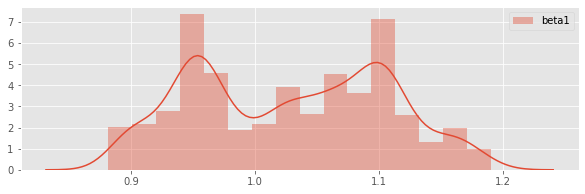

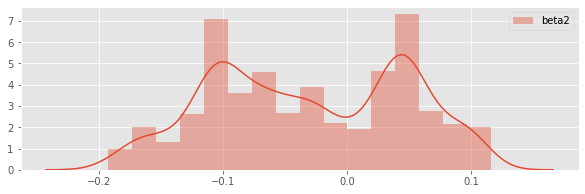

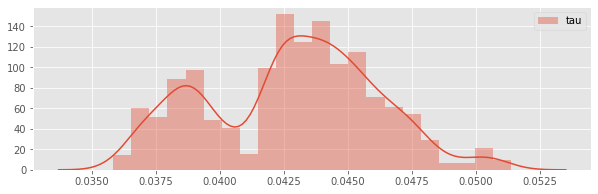

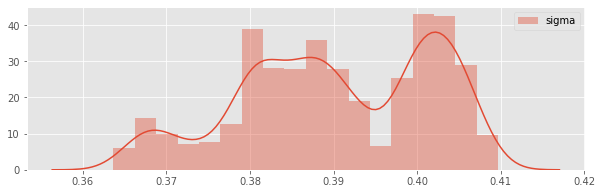

In [295]:
# Get parameter samples
hmc_samples_ar2 = mcmc.get_samples()
nodes_ar2 = ["beta1", "beta2", "tau", "sigma"]
for node in nodes_ar2:
    plt.figure(figsize=(10,3))
    sns.distplot(hmc_samples_ar2[node], label=node)
    plt.legend()
    plt.show()

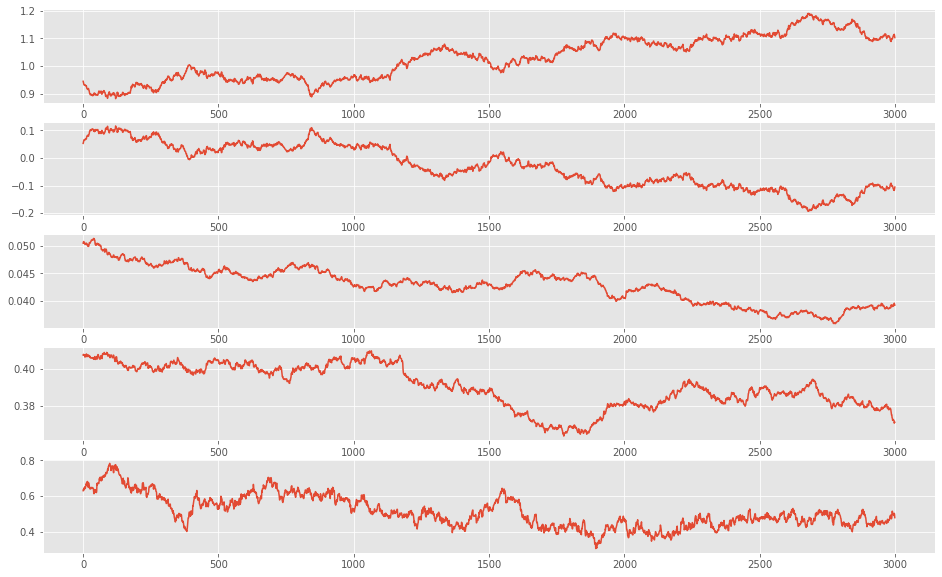

In [296]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
ax1.plot(hmc_samples_ar2['beta1'])
ax2.plot(hmc_samples_ar2['beta2'])
ax3.plot(hmc_samples_ar2['tau'])
ax4.plot(hmc_samples_ar2['sigma'])
ax5.plot(hmc_samples_ar2['z_prev1'])

In [0]:
# Get predictions
y_hat_ar2 = compute_predictions(hmc_samples_ar2["y_hat"], yt_std, yt_mean)

In [298]:
compute_error(yt_true, y_hat_ar2)

[0.27216018514172613, 40.476017, 1.968937, 51.76218, 0]

### AR24

In [299]:
# Start time
tic = time.time()

# Run MCMC
nuts_kernel = NUTS(model=model_AR24, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR24, max_tree_depth=8, step_size=1e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [02:30<00:00, 26.58it/s, 255 steps of size 3.43e-03. acc. prob=0.96]


Total time: 3.012m


In [300]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.78      0.13      0.71      0.67      1.00      2.94      1.99
     beta24      0.22      0.12      0.29     -0.00      0.33      2.96      1.97
  noises[0]      1.25      1.38      1.44     -0.92      3.35      3.15      1.82
  noises[1]      0.44      0.82      0.45     -0.86      1.82     80.31      1.09
  noises[2]     -1.42      0.62     -1.42     -2.37     -0.32      9.55      1.15
  noises[3]     -0.45      0.79     -0.37     -1.84      0.63      3.67      1.77
  noises[4]     -0.82      1.23     -1.15     -2.65      1.19      3.83      1.47
  noises[5]     -0.08      0.56     -0.02     -1.13      0.81      3.48      1.66
  noises[6]     -0.90      0.65     -0.95     -2.07      0.11      6.42      1.63
  noises[7]      0.39      0.44      0.41     -0.35      1.01      3.45      1.71
  noises[8]     -0.15      0.50     -0.15     -0.98      0.64     20.90      1.02
  noises[9]    

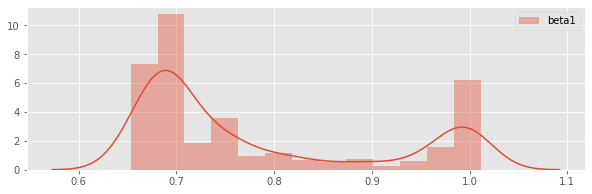

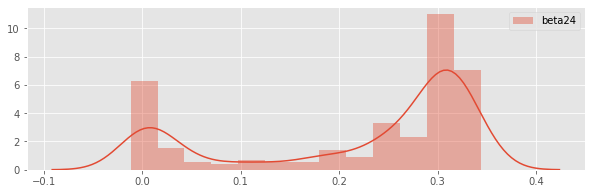

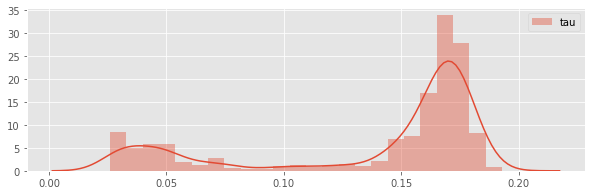

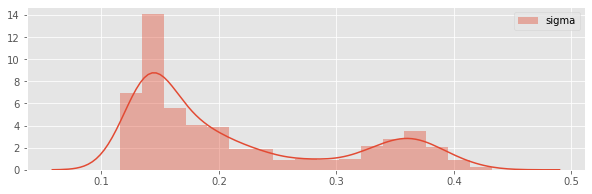

In [301]:
# Get parameter samples
hmc_samples_ar24 = mcmc.get_samples()
nodes_ar24 = ["beta1", "beta24", "tau", "sigma"]
for node in nodes_ar24:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar24[node], label=node)
  plt.legend()
  plt.show()

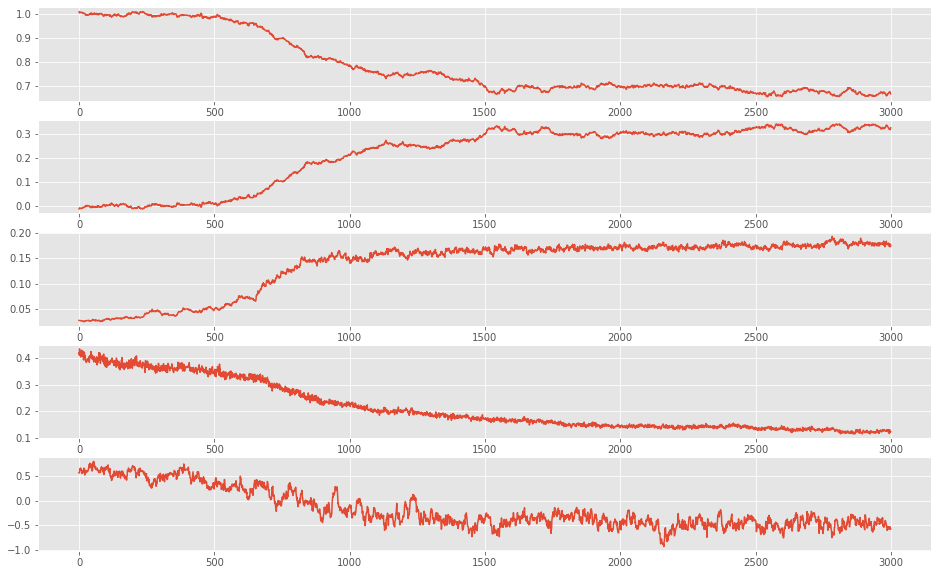

In [302]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
ax1.plot(hmc_samples_ar24['beta1'])
ax2.plot(hmc_samples_ar24['beta24'])
ax3.plot(hmc_samples_ar24['tau'])
ax4.plot(hmc_samples_ar24['sigma'])
ax5.plot(hmc_samples_ar24['z_prev1'])

In [0]:
# Get predictions
y_hat_ar24 = compute_predictions(hmc_samples_ar24["y_hat"], yt_std, yt_mean)

In [304]:
compute_error(yt_true, y_hat_ar24)

[0.5513860869608739, 21.480295, 1.044899, 25.1911, 0]

### AR168

In [305]:
# Start time
tic = time.time()

# Run MCMC
nuts_kernel = NUTS(model=model_AR168, max_tree_depth=8)
#nuts_kernel = NUTS(model=model_AR168, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [11:30<00:00,  5.79it/s, 255 steps of size 2.16e-03. acc. prob=0.78]


Total time: 12.984m


In [306]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.64      0.03      0.64      0.60      0.69      7.40      1.14
    beta168      0.01      0.01      0.01     -0.01      0.02     13.00      1.15
     beta24      0.35      0.03      0.35      0.31      0.39      8.07      1.03
  noises[0]      5.46      0.49      5.53      4.60      6.21     35.12      1.11
  noises[1]      0.76      0.33      0.74      0.21      1.31     33.96      1.03
  noises[2]     -0.98      0.39     -0.99     -1.61     -0.34    126.25      1.02
  noises[3]     -0.70      0.37     -0.69     -1.27     -0.07    173.08      1.00
  noises[4]     -1.34      0.41     -1.37     -2.02     -0.68     34.43      1.00
  noises[5]      0.09      0.41      0.11     -0.58      0.71     52.56      1.03
  noises[6]     -0.21      0.36     -0.21     -0.75      0.42    151.63      1.01
  noises[7]      0.27      0.38      0.27     -0.34      0.88    161.40      1.01
  noises[8]    

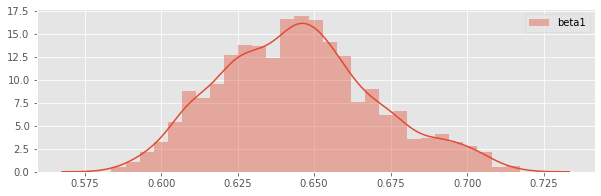

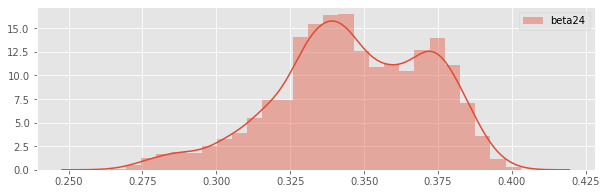

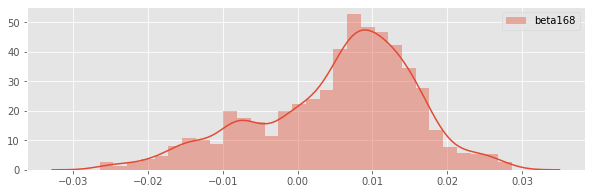

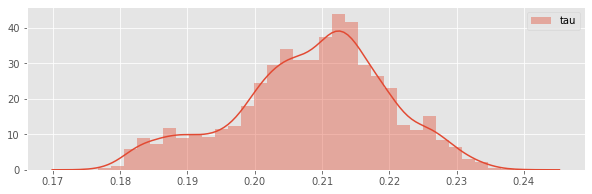

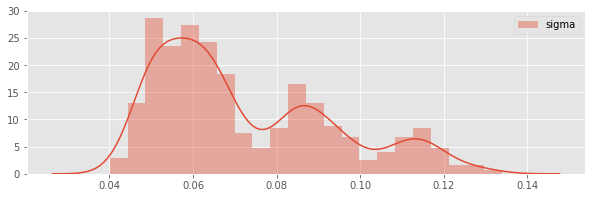

In [307]:
# Get parameter samples
hmc_samples_ar168 = mcmc.get_samples()
nodes_ar168 = ["beta1", "beta24", "beta168", "tau", "sigma"]
for node in nodes_ar168:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar168[node], label=node)
  plt.legend()
  plt.show()

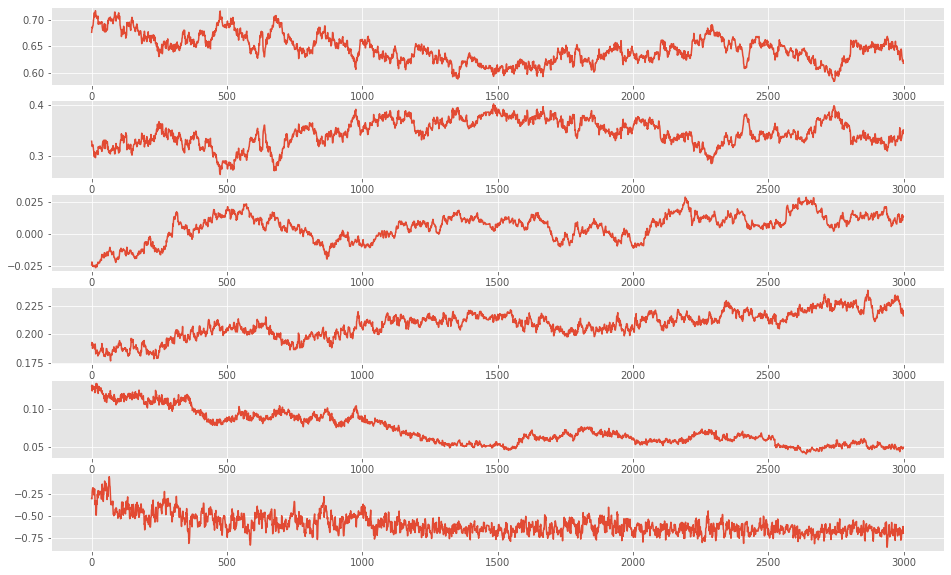

In [308]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1)
ax1.plot(hmc_samples_ar168['beta1'])
ax2.plot(hmc_samples_ar168['beta24'])
ax3.plot(hmc_samples_ar168['beta168'])
ax4.plot(hmc_samples_ar168['tau'])
ax5.plot(hmc_samples_ar168['sigma'])
ax6.plot(hmc_samples_ar168['z_prev1'])

In [0]:
# Get predictions
y_hat_ar168 = compute_predictions(hmc_samples_ar168["y_hat"], yt_std, yt_mean)

In [310]:
compute_error(yt_true, y_hat_ar168)

[0.48843762502783045, 21.392447, 1.0406256, 26.134457, 0]

### AR1 + Inputs

In [311]:
# Start time
tic = time.time()

X_t = np.concatenate([Xt_train[1:,:], Xt_test], axis=0)
# X_t = np.concatenate([Xt_train[0][np.newaxis, :], Xt_train, Xt_test], axis=0)
# X_t = np.concatenate([Xt_train, Xt_test], axis=0)

# Run MCMC
nuts_kernel = NUTS(model=model_AR1x, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR1x, max_tree_depth=8, step_size=1e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, X=X_t, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [01:27<00:00, 45.76it/s, 255 steps of size 2.55e-03. acc. prob=0.83]


Total time: 1.523m


In [312]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.88      0.01      0.88      0.86      0.90      9.24      1.28
     eta[0]     -0.11      0.03     -0.10     -0.16     -0.06      5.10      1.48
     eta[1]     -0.02      0.02     -0.02     -0.06      0.02      6.23      1.54
     eta[2]      0.00      0.01      0.00     -0.01      0.02      4.08      2.06
     eta[3]      0.04      0.01      0.04      0.03      0.05     15.20      1.02
  noises[0]      6.07      0.25      6.10      5.65      6.47      8.65      1.10
  noises[1]     -0.25      0.19     -0.26     -0.55      0.02     31.66      1.12
  noises[2]     -1.07      0.18     -1.06     -1.35     -0.77     26.53      1.01
  noises[3]     -1.13      0.18     -1.13     -1.42     -0.81     20.51      1.09
  noises[4]      0.75      0.19      0.75      0.42      1.03     19.34      1.10
  noises[5]     -0.68      0.19     -0.68     -1.00     -0.39     17.50      1.12
  noises[6]    

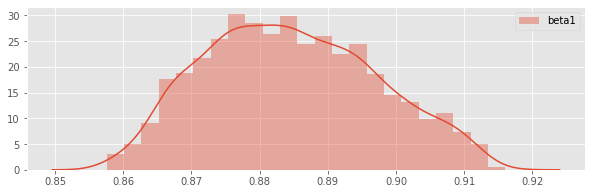

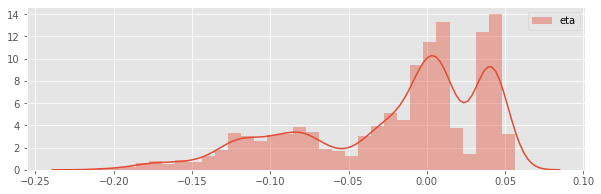

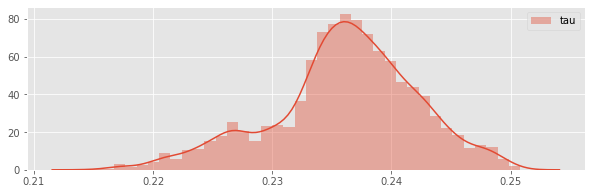

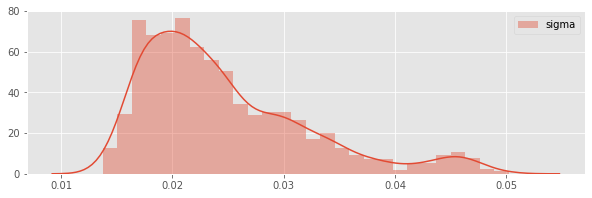

In [313]:
# Get parameter samples
hmc_samples_ar1x = mcmc.get_samples()
nodes_ar1x = ["beta1", "eta","tau", "sigma"]
for node in nodes_ar1x:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar1x[node], label=node)
  plt.legend()
  plt.show()

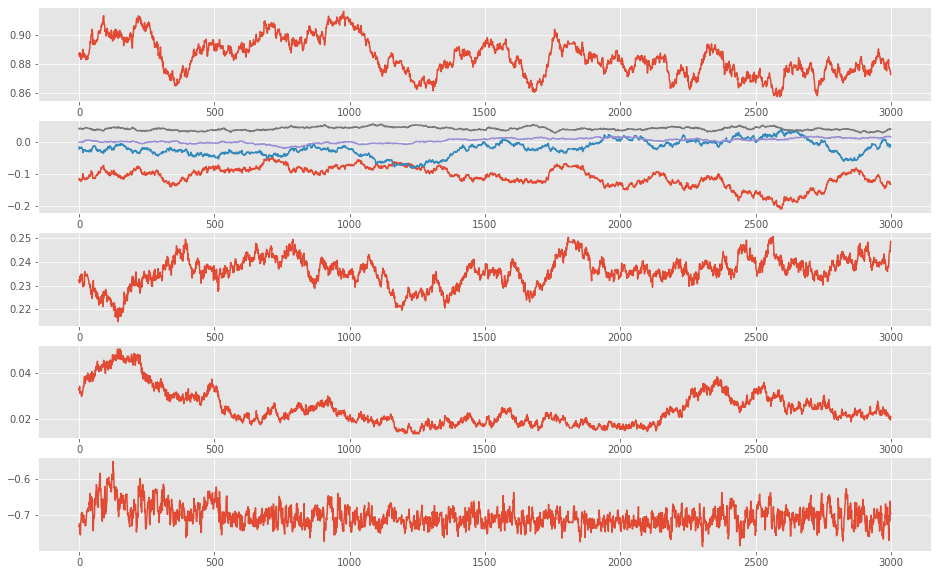

In [314]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
ax1.plot(hmc_samples_ar1x['beta1'])
ax2.plot(hmc_samples_ar1x['eta'])
ax3.plot(hmc_samples_ar1x['tau'])
ax4.plot(hmc_samples_ar1x['sigma'])
ax5.plot(hmc_samples_ar1x['z_prev1'])

In [0]:
# Get predictions
y_hat_ar1x = compute_predictions(hmc_samples_ar1x["y_hat"], yt_std, yt_mean)

In [316]:
compute_error(yt_true, y_hat_ar1x)

[0.03872207534627137, 28.006554, 1.3623657, 31.647163, 0]

### AR2 + Inputs

In [317]:
# Start time
tic = time.time()

X_t = np.concatenate([Xt_train[2:,:], Xt_test], axis=0)

# Run MCMC
nuts_kernel = NUTS(model=model_AR2x, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR2x, max_tree_depth=8, step_size=1e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, X=X_t, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [01:38<00:00, 40.75it/s, 255 steps of size 9.63e-05. acc. prob=0.95]


Total time: 1.825m


In [318]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.48      0.00      0.48      0.48      0.49      2.65      3.65
      beta2      0.53      0.00      0.53      0.53      0.53     13.46      1.01
     eta[0]      0.05      0.00      0.05      0.04      0.05      5.13      1.58
     eta[1]     -0.03      0.00     -0.03     -0.03     -0.03      3.06      1.97
     eta[2]     -0.01      0.00     -0.01     -0.01     -0.01     35.30      1.02
     eta[3]     -0.00      0.00     -0.00     -0.00     -0.00      3.45      1.73
  noises[0]      0.96      0.00      0.96      0.96      0.96      7.79      1.04
  noises[1]     -0.95      0.00     -0.95     -0.96     -0.95      2.52      3.16
  noises[2]     -0.00      0.00     -0.00     -0.00     -0.00      8.58      1.00
  noises[3]      0.15      0.00      0.15      0.15      0.15     11.76      1.10
  noises[4]      1.59      0.00      1.59      1.59      1.59      8.91      1.14
  noises[5]    

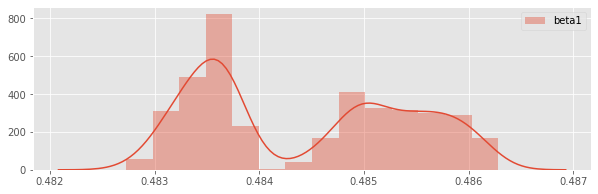

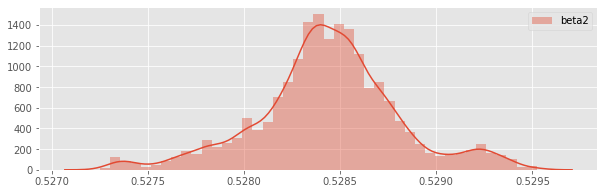

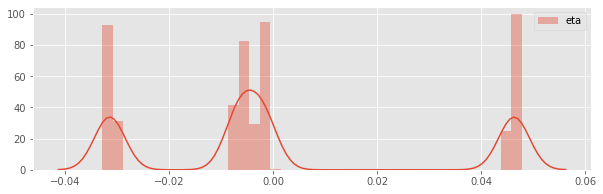

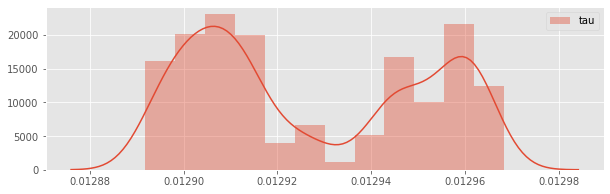

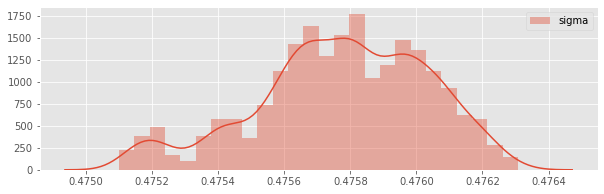

In [319]:
# Get parameter samples
hmc_samples_ar2x = mcmc.get_samples()
nodes_ar2x = ["beta1", "beta2", "eta","tau", "sigma"]
for node in nodes_ar2x:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar2x[node], label=node)
  plt.legend()
  plt.show()

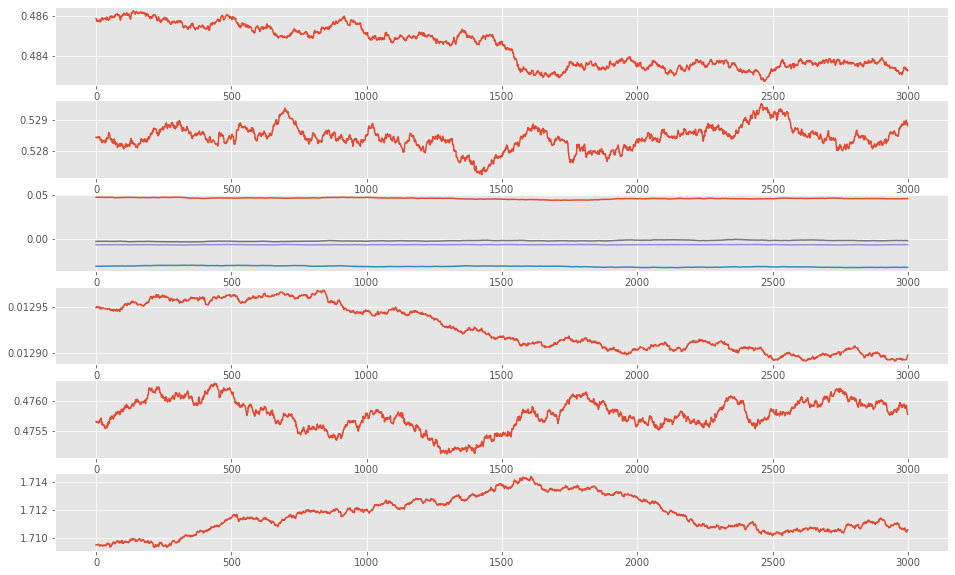

In [320]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1)
ax1.plot(hmc_samples_ar2x['beta1'])
ax2.plot(hmc_samples_ar2x['beta2'])
ax3.plot(hmc_samples_ar2x['eta'])
ax4.plot(hmc_samples_ar2x['tau'])
ax5.plot(hmc_samples_ar2x['sigma'])
ax6.plot(hmc_samples_ar2x['z_prev1'])

Notice the flat structure at the eta latent variable, this might be an error that the algorithm couldn't get out of some sampling zone. Should be further investigated witht the step size, all other variables behave well. When trying to adjust the step size, eta was better but disrupted the other variables, therefore we decided to leave it as is.

In [0]:
# Get predictions
y_hat_ar2x = compute_predictions(hmc_samples_ar2x["y_hat"], yt_std, yt_mean)

In [322]:
compute_error(yt_true, y_hat_ar2x)

[-0.1738895271693867, 61.61176, 2.9970753, 75.39698, 0]

### AR24 + Inputs

In [323]:
# Start time
tic = time.time()

X_t = np.concatenate([Xt_train[24:,:], Xt_test], axis=0)

# Run MCMC
nuts_kernel = NUTS(model=model_AR24x, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR24x, max_tree_depth=8, step_size=1e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, X=X_t, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [02:40<00:00, 24.93it/s, 255 steps of size 1.44e-03. acc. prob=0.91]


Total time: 3.228m


In [324]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.54      0.02      0.54      0.51      0.56     16.89      1.01
     beta24      0.37      0.02      0.37      0.34      0.39      7.97      1.19
     eta[0]     -0.01      0.02     -0.01     -0.04      0.01      8.52      1.09
     eta[1]     -0.12      0.02     -0.12     -0.16     -0.09      4.27      1.46
     eta[2]     -0.01      0.01     -0.01     -0.02     -0.01      5.55      1.93
     eta[3]      0.03      0.01      0.03      0.02      0.04      5.03      1.31
  noises[0]      3.55      0.19      3.55      3.23      3.87     15.86      1.06
  noises[1]      0.33      0.14      0.35      0.11      0.56     45.95      1.07
  noises[2]     -2.52      0.13     -2.51     -2.73     -2.29     55.26      1.06
  noises[3]     -1.72      0.14     -1.72     -1.96     -1.51     38.88      1.07
  noises[4]     -1.76      0.15     -1.76     -2.00     -1.51     57.57      1.03
  noises[5]    

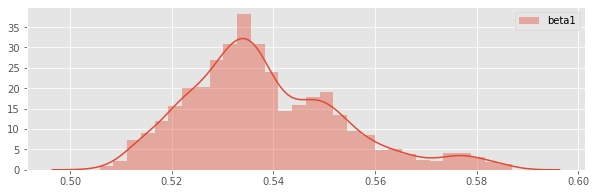

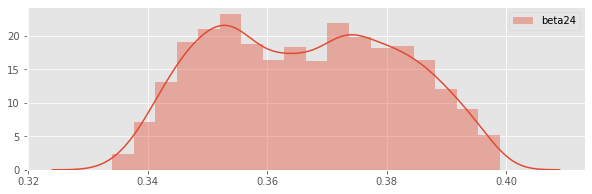

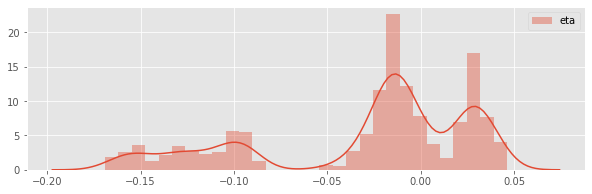

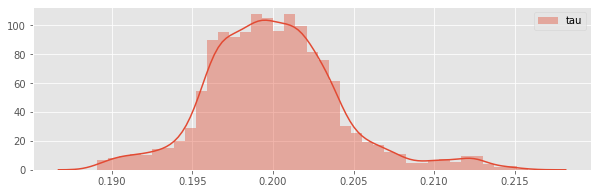

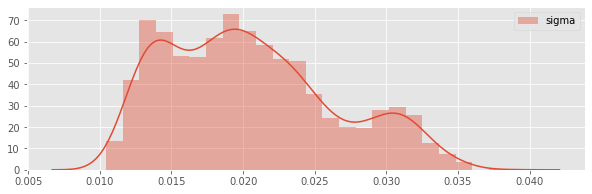

In [325]:
# Get parameter samples
hmc_samples_ar24x = mcmc.get_samples()
nodes_ar24x = ["beta1", "beta24", "eta", "tau", "sigma"]
for node in nodes_ar24x:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar24x[node], label=node)
  plt.legend()
  plt.show()

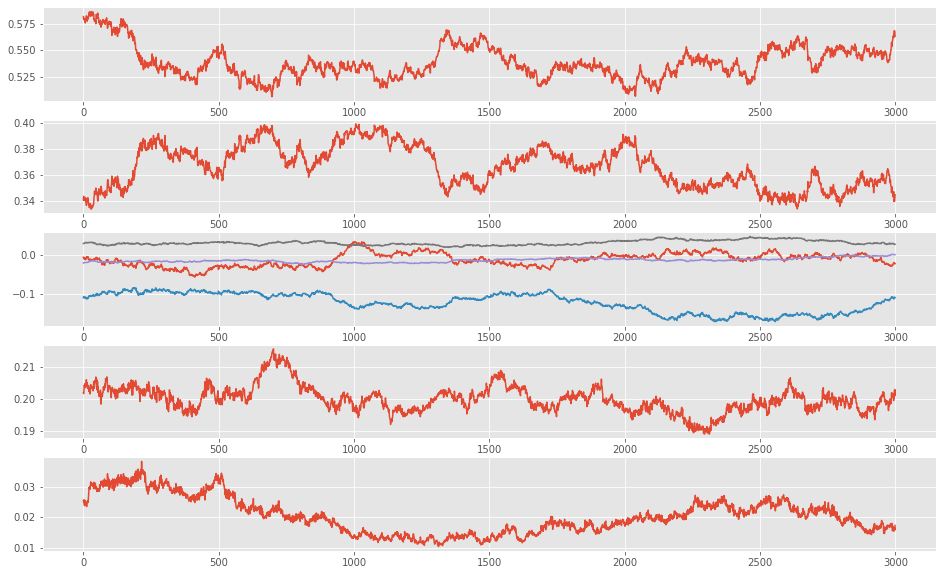

In [326]:
# Trace plots
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
ax1.plot(hmc_samples_ar24x['beta1'])
ax2.plot(hmc_samples_ar24x['beta24'])
ax3.plot(hmc_samples_ar24x['eta'])
ax4.plot(hmc_samples_ar24x['tau'])
ax5.plot(hmc_samples_ar24x['sigma'])

In [0]:
# Get predictions
y_hat_ar24x = compute_predictions(hmc_samples_ar24x["y_hat"], yt_std, yt_mean)

In [328]:
compute_error(yt_true, y_hat_ar24x)

[0.6813601965185216,
 17.241308,
 0.83869535,
 22.04445,
 DeviceArray(0.21021831, dtype=float32)]

### AR168 + Inputs

In [329]:
# Start time
tic = time.time()

X_t = np.concatenate([Xt_train[168:,:], Xt_test], axis=0)

# Run MCMC
nuts_kernel = NUTS(model=model_AR168x, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR168x, max_tree_depth=8, step_size=1e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, X=X_t, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [09:40<00:00,  6.89it/s, 255 steps of size 1.12e-03. acc. prob=0.68]


Total time: 11.086m


In [330]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.67      0.02      0.67      0.63      0.69     13.31      1.30
    beta168     -3.37      3.58     -4.07     -7.88      2.66      2.87      2.09
     beta24      0.13      0.01      0.13      0.11      0.14     15.50      1.13
     eta[0]      0.02      0.02      0.01     -0.02      0.05      6.35      1.02
     eta[1]     -0.14      0.02     -0.14     -0.16     -0.11      6.18      1.27
     eta[2]     -0.04      0.01     -0.04     -0.05     -0.03     11.74      1.01
     eta[3]      0.02      0.01      0.02      0.01      0.03      7.49      1.01
  noises[0]      5.24      0.28      5.27      4.77      5.62     31.54      1.01
  noises[1]     -0.42      0.19     -0.43     -0.72     -0.12     30.69      1.08
  noises[2]     -1.95      0.21     -1.95     -2.31     -1.61    155.22      1.01
  noises[3]     -1.60      0.22     -1.61     -1.98     -1.22    128.67      1.00
  noises[4]    

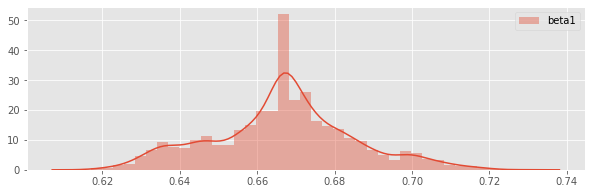

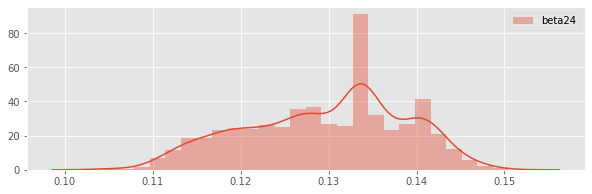

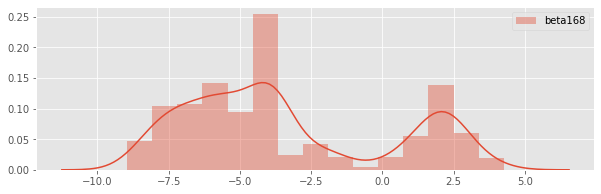

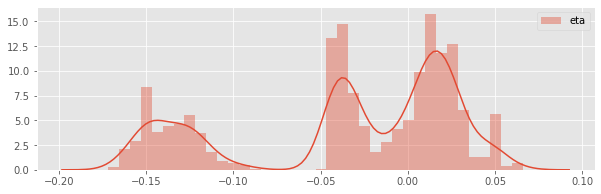

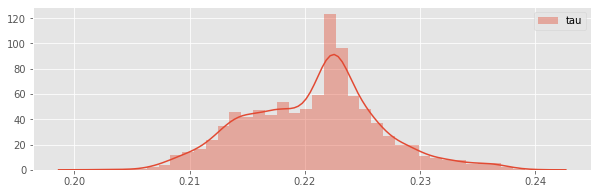

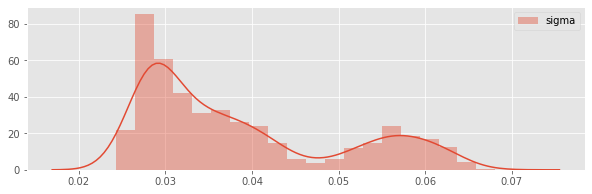

In [331]:
# Get parameter samples
hmc_samples_ar168x = mcmc.get_samples()
nodes_ar168x = ["beta1", "beta24", "beta168","eta", "tau", "sigma"]
for node in nodes_ar168x:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar168x[node], label=node)
  plt.legend()
  plt.show()

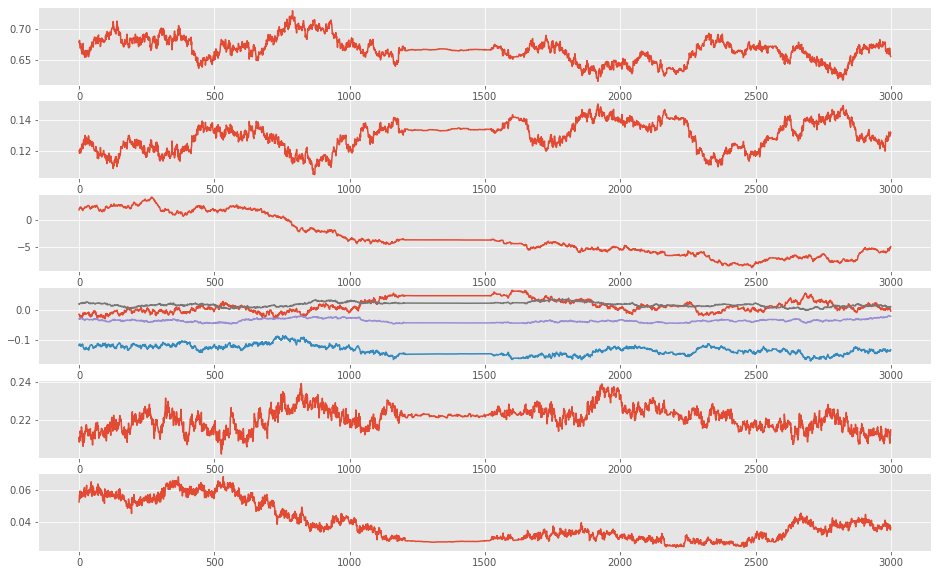

In [332]:
# Trace plots
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1)
ax1.plot(hmc_samples_ar168x['beta1'])
ax2.plot(hmc_samples_ar168x['beta24'])
ax3.plot(hmc_samples_ar168x['beta168'])
ax4.plot(hmc_samples_ar168x['eta'])
ax5.plot(hmc_samples_ar168x['tau'])
ax6.plot(hmc_samples_ar168x['sigma'])

In [0]:
# Get predictions
y_hat_ar168x = compute_predictions(hmc_samples_ar168x["y_hat"], yt_std, yt_mean)

In [334]:
compute_error(yt_true, y_hat_ar168x)

[0.8136312972805356,
 10.713025,
 0.52113014,
 14.575536,
 DeviceArray(0.65473104, dtype=float32)]

# Results
Here we present the modelling results and calculate the errors.

In [335]:
# Compute errors
if all_buildings:
    e_lr = compute_error(y_true, y_hat_lr)
    e_blr = compute_error(y_true, y_hat_blr)
    e_hm = compute_error(y_true, y_hat_hm)
    errors = [e_lr, e_blr, e_hm]

    # Save errors to DataFrame and show
    pd.set_option('float_format', '{:.3f}'.format)
    df_results = pd.DataFrame(data=errors,
                            index=['Linear Regression',
                                    'Bayesian LR',
                                    'Hierarchical'
                                    ],
                            columns=['CORR', 'MAE', 'RAE', 'RMSE', 'R2'])
else:
    e_lr = compute_error(y_true, y_hat_lr)
    e_blr = compute_error(y_true, y_hat_blr)
    e_ar1 = compute_error(yt_true, y_hat_ar1)
    e_ar2 = compute_error(yt_true, y_hat_ar2)
    e_ar24 = compute_error(yt_true, y_hat_ar24)
    e_ar168 = compute_error(yt_true, y_hat_ar168)
    e_ar1x = compute_error(yt_true, y_hat_ar1x)
    e_ar2x = compute_error(yt_true, y_hat_ar2x)
    e_ar24x = compute_error(yt_true, y_hat_ar24x)
    e_ar168x = compute_error(yt_true, y_hat_ar168x)
    errors = [e_lr, e_blr, e_ar1, e_ar2, e_ar24, e_ar168, e_ar1x, e_ar2x, e_ar24x, e_ar168x]

    # Save errors to DataFrame and show
    pd.set_option('float_format', '{:.3f}'.format)
    df_results = pd.DataFrame(data=errors,
                            index=['Linear Regression',
                                   'Bayesian LR',
                                   'AR1',
                                   'AR2',
                                   'AR24',
                                   'AR168',
                                   'AR1x',
                                   'AR2x',
                                   'AR24x',
                                   'AR168x',
                                    ],
                            columns=['CORR', 'MAE', 'RAE', 'RMSE', 'R2'])
df_results
#print(df_results.to_latex())

CORR    MAE   RAE   RMSE          R2
Linear Regression  0.768 14.394 0.700 19.495       0.382
Bayesian LR        0.750 37.432 1.821 40.979           0
AR1               -0.384 26.374 1.283 29.761           0
AR2                0.272 40.476 1.969 51.762           0
AR24               0.551 21.480 1.045 25.191           0
AR168              0.488 21.392 1.041 26.134           0
AR1x               0.039 28.007 1.362 31.647           0
AR2x              -0.174 61.612 2.997 75.397           0
AR24x              0.681 17.241 0.839 22.044  0.21021831
AR168x             0.814 10.713 0.521 14.576  0.65473104

It can be seen from the previous table that linear regression and bayesian linear regression models are quite hard to beat. The normal LDS models without inputs don't perform very well, this might be due to the fact that the energy consumption in the building in the previous hours is probably not the most important variable when forecasting. However, LDS models with inputs perform very well, even beating the linear models at AR168x. It can be seen from the trace plots of the previous section that almost all latent variables were very well investigated by the NUTS algorithm and the results shows this.

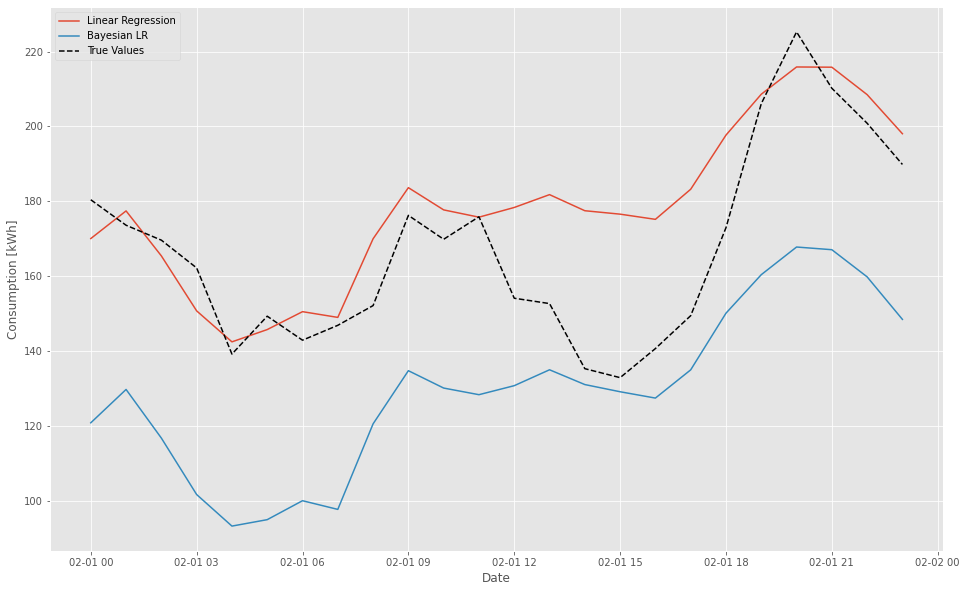

In [337]:
# Plot forecast
if all_buildings:
    plt.plot(y_hat_lr, label='Linear Regression')
    plt.plot(y_hat_blr, label='Bayesian LR')
    plt.plot(y_hat_hm, label='Hierarchical')
    plt.plot(y_true, 'k--', label='True Values')
    plt.ylabel('Consumption [kWh]')
    plt.xlabel('Date')
    plt.legend()
    plt.savefig('lr_all.png')
    files.download("lr_all.png")
else:
    plt.plot(forecast_dates, y_hat_lr, label='Linear Regression')
    plt.plot(forecast_dates, y_hat_blr, label='Bayesian LR')
    plt.plot(forecast_dates, y_true, 'k--', label='True Values')
    plt.ylabel('Consumption [kWh]')
    plt.xlabel('Date')
    plt.legend()
    # plt.savefig('lr_6m.png')
    # files.download("lr_6m.png")

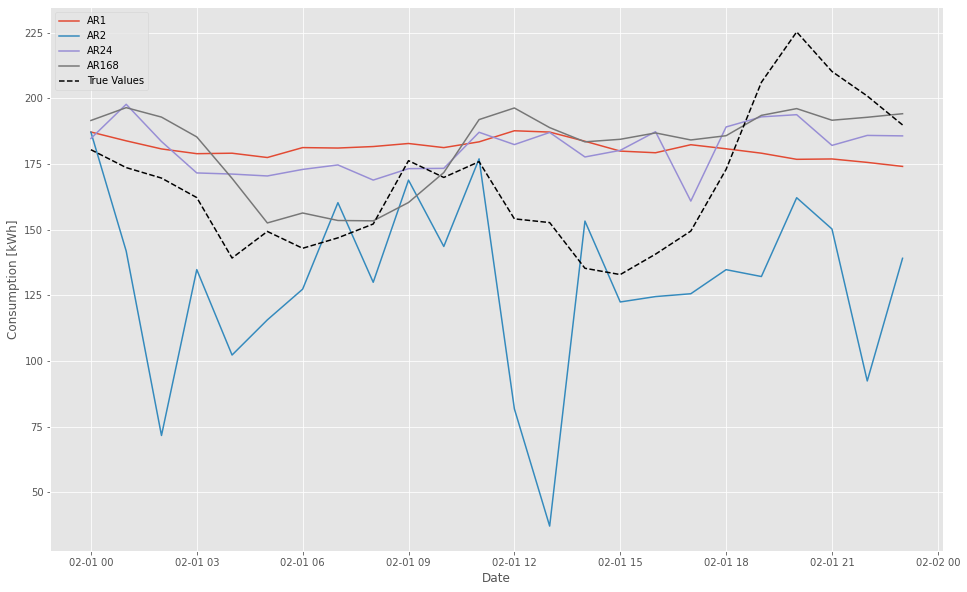

In [338]:
# Plot forecast
plt.plot(forecast_dates, y_hat_ar1, label='AR1')
plt.plot(forecast_dates, y_hat_ar2, label='AR2')
plt.plot(forecast_dates, y_hat_ar24, label='AR24')
plt.plot(forecast_dates, y_hat_ar168, label='AR168')
plt.plot(forecast_dates, yt_true, 'k--', label='True Values')
plt.ylabel('Consumption [kWh]')
plt.xlabel('Date')
plt.legend()
# plt.savefig('ar_6m.png')
# files.download("ar_6m.png")

Notice the big peaks in AR2 and very flat structure of AR1, the time dependency affect these two models a lot. AR24 and AR168 seem to follow the real values better.

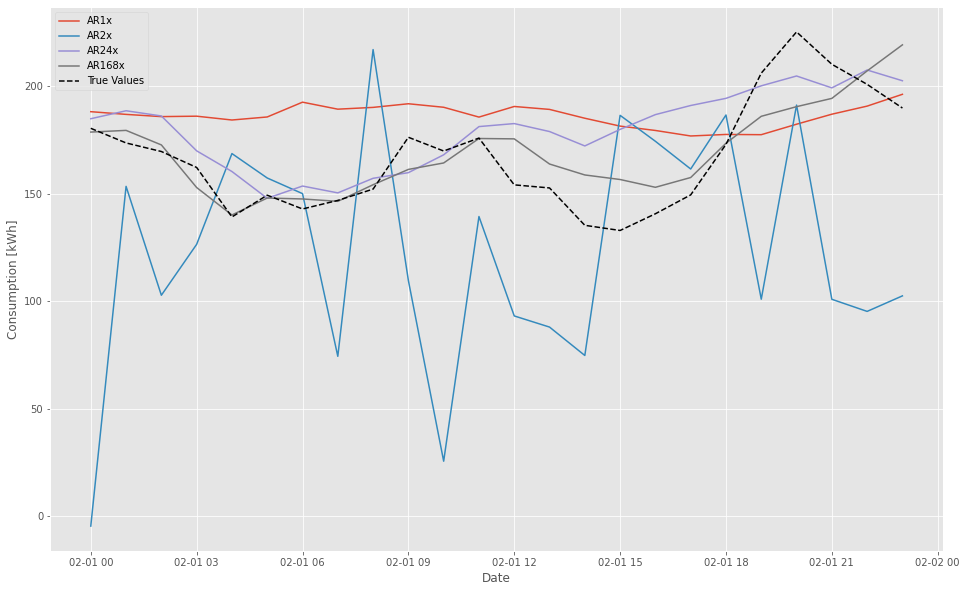

In [339]:
# Plot forecast
plt.plot(forecast_dates, y_hat_ar1x, label='AR1x')
plt.plot(forecast_dates, y_hat_ar2x, label='AR2x')
plt.plot(forecast_dates, y_hat_ar24x, label='AR24x')
plt.plot(forecast_dates, y_hat_ar168x, label='AR168x')
plt.plot(forecast_dates, yt_true, 'k--', label='True Values')
plt.ylabel('Consumption [kWh]')
plt.xlabel('Date')
plt.legend()
# plt.savefig('arx_6m.png')
# files.download("arx_6m.png")

When considering weather inputs, the ARx models series perform better when increasing the number of lags (information) on the current state t. AR168x amazingly follows the true values very close. 

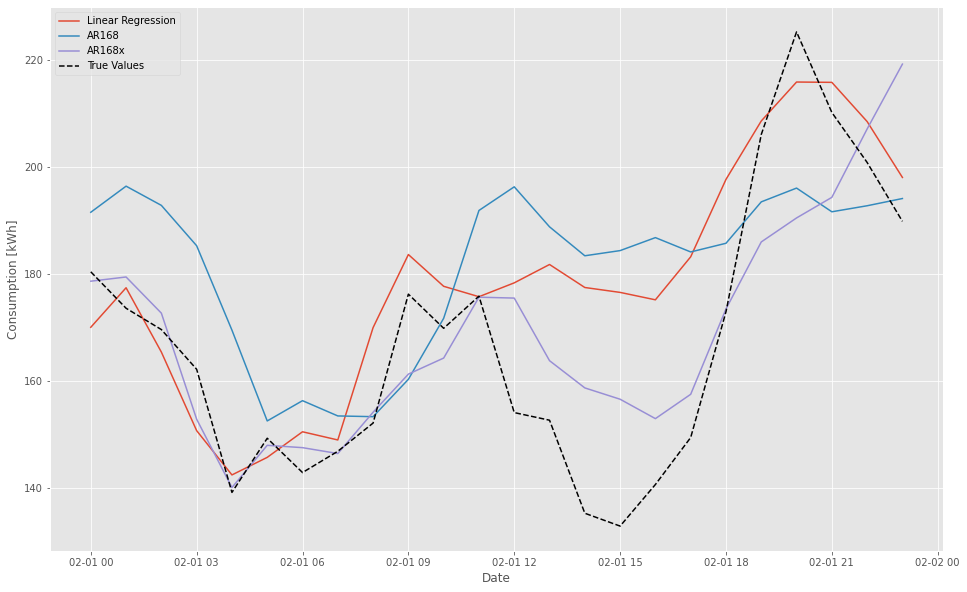

In [340]:
# Plot forecast
plt.plot(forecast_dates, y_hat_lr, label='Linear Regression')
plt.plot(forecast_dates, y_hat_ar168, label='AR168')
plt.plot(forecast_dates, y_hat_ar168x, label='AR168x')
plt.plot(forecast_dates, yt_true, 'k--', label='True Values')
plt.ylabel('Consumption [kWh]')
plt.xlabel('Date')
plt.legend()
# plt.savefig('6m.png')
# files.download("6m.png")

# Pandas-profiling

In [0]:
# Generate descriptive statistics reports
# If it doesn't work try uninstalling pandas-profiling, re-install it, and restart runtime
profile_meta = ProfileReport(df_meta,
                             title='Building info',
                             minimal=True,
                             html={'style':{'full_width':True}})
profile_data = ProfileReport(df,
                             title='Electricity consumption in households',
                             minimal=True,
                             html={'style':{'full_width':True}})
profile_weather = ProfileReport(df_weather,
                                title='Weather',
                                minimal=True,
                                html={'style':{'full_width':True}})

In [0]:
# Export reports
# profile_meta.to_file(output_file="info.html")
# profile_weather.to_file(output_file="weather.html")
# profile_data.to_file(output_file="data.html")
# files.download('info.html')
# files.download('weather.html')
# files.download('data.html')